# Script: Data and Statistics
Author: Alyde Bles  
Student Number: 2826862  
Date: 31/12/2024

This notebook prepares the data for the main analysis, including constructing the target variable, the Niño 3.4 index, and the explanatory variables: SST anomalies, zonal wind stress, and thermocline depth. Additionally, it generates the necessary graphs for visualising data and statistics. 

Table of Contents

1. [Packages](#Packages)

2. [Thermocline Depth Calculations](#Thermocline-Depth-Calculations)  
   - Calculations to construct the thermocline depth dataset from subsurface temperatures.  

3. [Preparing All Variables](#Prepare-Variables)  
   - 3.1 [SST and Zonal Wind Stress](#SST-and-Zonal-Wind-Stress)  
     Preparing the SST and zonal wind stress anomaly dataset.  
     - 3.1.1 [Niño 3.4 Index and Absolute](#Niño-3.4-Index-and-Absolute)  
       Preparing the Niño 3.4 index and absolute values.  
   - 3.2 [Thermocline Depth](#Thermocline-Depth)  
     Preparing the thermocline depth anomaly dataset.  

4. [Visualisations](#Visualisations)  
   - 4.1 [Summary Table](#Summary-Table)  
     Calculates summary statistics for the summary table.  
   - 4.2 [General Spatial Plots](#General-Spatial-Plots)  
     Generates plots for long-term means and El Niño/La Niña events for all three variables.  
   - 4.3 [Hovmöller Diagrams](#Hovmöller-Diagrams)  
     Creates Hovmöller diagrams for the three variables.  
   - 4.4 [Niño Regions](#Niño-Regions)  
     Plots the Niño indices for visual representation.  

     






## Packages

In [1]:
# Importing necessary libraries
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import netCDF4 as nc
from datetime import datetime
import sys, os
import urllib.request as opener
import xarray as xr
import statsmodels.api as sm
import zipfile
import cftime
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
from scipy.stats import pearsonr
import zipfile
import tempfile
from matplotlib.patches import Rectangle

import matplotlib.gridspec as gridspec





## Thermocline Depth Calculations
Here the 20 degrees isotherm, representing the thermocline depth, is calculated from subsurface temperature dataset.


In [2]:
def calculate_thermcoline_depth(file_sub_surface, isovalue=20):
    """
    Calculates the depth where the temperature reaches 20 degrees Celsius from subsurface temperature data.
    
    Parameters:
        file_sub_surface: The dataset containing temperature and depth data.
        isovalue: Target temperature in Celsius to find the depth (default is 20°C).
    
    Returns:
        Three arrays representing the depth of the isotherm, latitudes, and longitudes.
    """
    # Extract data from the file
    depths = file_sub_surface.variables['depth'][:]
    temperature = file_sub_surface.variables['temperature'][:].data[0]  # Assuming the first time step
    latitudes = file_sub_surface.variables['lat'][:]
    longitudes = file_sub_surface.variables['lon'][:]

    # Convert temperature from Kelvin to Celsius
    temperature_celsius = temperature - 273.15

    # Prepare an array to hold the depth of the isotherm
    isotherm_depth = np.full((len(latitudes), len(longitudes)), np.nan)

    # Go through each point on the grid
    for lat_idx in range(len(latitudes)):
        for lon_idx in range(len(longitudes)):
            temp_profile = temperature_celsius[:, lat_idx, lon_idx]

            # Ignore points where all temperatures are NaN
            if np.all(np.isnan(temp_profile)):
                continue
            
            # Find where the temperature profile crosses the specified isotherm
            below_isotherm = temp_profile < isovalue
            above_isotherm = temp_profile >= isovalue
            crossing_indices = np.where(below_isotherm & np.roll(above_isotherm, 1))[0]
            
            # Calculate the depth at the crossing point
            if len(crossing_indices) > 0:
                idx = crossing_indices[0]
                if idx > 0:
                    depth1, depth2 = depths[idx - 1], depths[idx]
                    temp1, temp2 = temp_profile[idx - 1], temp_profile[idx]
                    isotherm_depth[lat_idx, lon_idx] = np.interp(isovalue, [temp1, temp2], [depth1, depth2])
    
    return isotherm_depth, latitudes, longitudes


In [16]:
"""
This script processes thermocline depth data, specifically calculating the 20 degrees Celsius isotherm depth
from subsurface temperature for multiple years. It saves the processed data in a NetCDF file.
"""
# Set the range of years and months for data processing
start_year = 1940
end_year = 2023
months = [f"{month:02d}" for month in range(1, 13)]

# Set the location where the data files are stored
base_zip_path = 'Data/Data Raw/Thermocline Depth/'

# Prepare lists to keep track of all data
all_z20_depths = []
all_times = []

# Loop through each year and each month within that year
for year in range(start_year, end_year + 1):
    for month in months:
        # Set up paths for ZIP file and data file inside it
        zip_file_path = os.path.join(base_zip_path, f'EN.4.2.2.analyses.g10.{year}.zip')
        netcdf_file_name = f'EN.4.2.2.f.analysis.g10.{year}{month}.nc'

        # Make sure the ZIP file is there
        if not os.path.exists(zip_file_path):
            print(f"ZIP file not found: {zip_file_path}")
            continue

        try:
            # Open the ZIP file and access the specific data file
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                with zip_ref.open(netcdf_file_name) as nc_file:
                    with nc.Dataset('inmemory.nc', mode='r', memory=nc_file.read()) as file_sub_surface:
                        # Get the time data from the file
                        time = file_sub_surface.variables['time'][:]
                        all_times.append(time)

                        # Calculate the depth of the 20°C isotherm
                        z20_depths, latitudes, longitudes = calculate_thermcoline_depth(
                            file_sub_surface, isovalue=20
                        )
                        all_z20_depths.append(z20_depths)

                        print(f"Processed: {year}-{month}")

        except Exception as e:
            print(f"Error processing {year}-{month}: {e}")

# Combine all collected depth data into a single array
z20_combined = np.stack(all_z20_depths, axis=0)  # Stack depth arrays along the time dimension
all_times = np.concatenate(all_times)  # Merge all time data into one array

# Create a NetCDF dataset to store results
output_file = 'Data/Data Process/z20_depths_1940_2023.nc'
if os.path.exists(output_file):
    os.remove(output_file)  # Delete the existing file to avoid conflicts

with nc.Dataset(output_file, 'w') as ds:
    # Set up the dimensions based on the data
    ds.createDimension('time', len(all_times))
    ds.createDimension('latitude', len(latitudes))
    ds.createDimension('longitude', len(longitudes))

    # Define variables to store data
    time_var = ds.createVariable('time', 'f4', ('time',))
    lat_var = ds.createVariable('latitude', 'f4', ('latitude',))
    lon_var = ds.createVariable('longitude', 'f4', ('longitude',))
    z20_var = ds.createVariable('z20_depth', 'f4', ('time', 'latitude', 'longitude'), fill_value=np.nan)

    # Store the actual data in the variables
    time_var[:] = all_times
    lat_var[:] = latitudes
    lon_var[:] = longitudes
    z20_var[:, :, :] = z20_combined

    # Add descriptive attributes to the data
    ds.description = "Monthly z20 isotherm depths (20°C) from 1940 to 2023"
    time_var.units = "days since 1800-01-01 00:00:00"
    lat_var.units = "degrees north"
    lon_var.units = "degrees east"
    z20_var.units = "meters"

print(f"z20 depth dataset saved to {output_file}")




KeyboardInterrupt: 

## Preparing all the variables

### SST and Zonal Wind Stress

In [3]:
# This script calculates rolling climatological anomalies for sea surface temperature and wind stress data,
# saving the results as original data, anomalies, rolling anomalies, and standardized anomalies in new NetCDF files.

# Region of interest definition
region = {'lat_min': -30, 'lat_max': 30, 'lon_min': 120, 'lon_max': 285}

# File paths for input and output data
input_file_path = "Data/Data Raw/Sea Surface Temperature/sst.mnmean.nc"
output_file_path = "Data/Data Process/sst_with_anomalies.nc"
input_file_path_wind_stress = "Data/Data Raw/Wind stress/uflx.sfc.mon.mean.nc"
output_file_path_wind_stress = "Data/Data Process/wind_stress_with_anomalies.nc"

# Remove existing output files to ensure fresh start
for path in [output_file_path, output_file_path_wind_stress]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted existing file: {path}")

# Function to calculate rolling 30-year climatological anomalies
def calculate_and_save_anomalies_rolling(nc_path, var_name, output_path, rolling_window=30, rolling_mean_months=None):
    """
    Calculate rolling climatological anomalies and save them along with original data and standardized versions.
    """
    with nc.Dataset(nc_path, 'r') as ncfile:
        latitudes = ncfile.variables['lat'][:]
        longitudes = ncfile.variables['lon'][:]
        time = nc.num2date(ncfile.variables['time'][:], ncfile.variables['time'].units)
        time = [datetime.strptime(t.strftime('%Y-%m-%d'), '%Y-%m-%d') for t in time]
        data = ncfile.variables[var_name][:]

        anomalies = np.full_like(data, np.nan)
        standardized_anomalies = np.full_like(data, np.nan)
        rolling_anomalies = np.full_like(data, np.nan)  # Prepare array for smoothed anomalies

        for i in range(len(time)):
            if i < rolling_window * 12:
                climatology_start_index = 0
                climatology_end_index = rolling_window * 12 - 1
            else:
                climatology_start_index = i - rolling_window * 12 + 1
                climatology_end_index = i

            month_indices = [
                j for j in range(climatology_start_index, climatology_end_index + 1)
                if time[j].month == time[i].month
            ]

            climatology_mean = np.nanmean(data[month_indices, :, :], axis=0)
            climatology_std = np.nanstd(data[month_indices, :, :], axis=0)

            anomalies[i, :, :] = data[i, :, :] - climatology_mean
            standardized_anomalies[i, :, :] = np.where(climatology_std != 0, anomalies[i, :, :] / climatology_std, np.nan)

        # Smooth anomalies if specified
        if rolling_mean_months:
            for lat in range(data.shape[1]):
                for lon in range(data.shape[2]):
                    series = anomalies[:, lat, lon]
                    smoothed_series = pd.Series(series).rolling(window=rolling_mean_months, center=True, min_periods=1).mean()
                    rolling_anomalies[:, lat, lon] = smoothed_series.values

    # Save data to a new NetCDF file
    with nc.Dataset(output_path, 'w', format='NETCDF4') as new_ncfile:
        new_ncfile.createDimension('time', len(time))
        new_ncfile.createDimension('lat', len(latitudes))
        new_ncfile.createDimension('lon', len(longitudes))

        # Create variables and assign data
        time_var = new_ncfile.createVariable('time', 'f8', ('time',))
        lat_var = new_ncfile.createVariable('lat', 'f4', ('lat',))
        lon_var = new_ncfile.createVariable('lon', 'f4', ('lon',))
        original_var = new_ncfile.createVariable(var_name, 'f4', ('time', 'lat', 'lon'), zlib=True)
        anomaly_var = new_ncfile.createVariable(f"{var_name}_anomaly", 'f4', ('time', 'lat', 'lon'), zlib=True)
        anomaly_rolling_var = new_ncfile.createVariable(f"{var_name}_rolling_anomaly", 'f4', ('time', 'lat', 'lon'), zlib=True)
        standardized_var = new_ncfile.createVariable(f"{var_name}_standardized", 'f4', ('time', 'lat', 'lon'), zlib=True)

        time_var.units = 'days since 1800-01-01 00:00:00.0'
        time_var.calendar = 'gregorian'  # Explicitly set the calendar attribute
        lat_var.units = 'degrees north'
        lon_var.units = 'degrees east'

        time_var[:] = nc.date2num(time, units=time_var.units, calendar=time_var.calendar)
        lat_var[:] = latitudes
        lon_var[:] = longitudes
        original_var[:, :, :] = data
        anomaly_var[:, :, :] = anomalies
        anomaly_rolling_var[:, :, :] = rolling_anomalies
        standardized_var[:, :, :] = standardized_anomalies

        print(f"Saved processed data to {output_path}")

# Process and save SST anomalies
print("Processing SST anomalies...")
calculate_and_save_anomalies_rolling(input_file_path, 'sst', output_file_path, rolling_mean_months = 6)

# Process and save wind stress anomalies with a specified rolling mean
print("Processing wind stress anomalies...")
calculate_and_save_anomalies_rolling(input_file_path_wind_stress, 'uflx', output_file_path_wind_stress, rolling_mean_months=6)






Deleted existing file: Data/Data Process/sst_with_anomalies.nc
Deleted existing file: Data/Data Process/wind_stress_with_anomalies.nc
Processing SST anomalies...
Saved processed data to Data/Data Process/sst_with_anomalies.nc
Processing wind stress anomalies...
Saved processed data to Data/Data Process/wind_stress_with_anomalies.nc


#### Niño 3.4 Index and Absolute

In [4]:
# This script extracts Sea Surface Temperature (SST) data and anomalies for the Niño 3.4 region from a NetCDF file
# and saves the extracted data to CSV files.

# Define file path for the dataset containing SST and anomalies
file_path_with_anomalies = "Data/Data Process/sst_with_anomalies.nc"

# Define the geographical boundaries for the Niño 3.4 region
nino_34 = {'lat_min': -5, 'lat_max': 5, 'lon_min': 190, 'lon_max': 240}

def extract_nino34_data(file_path):
    """
    Extracts and returns the mean SST anomalies and SST values for the Niño 3.4 region.

    Parameters:
    - file_path: Path to the NetCDF file containing SST anomalies and SST data.

    Returns:
    - DataFrame with time and Niño 3.4 mean SST anomalies.
    - DataFrame with time and Niño 3.4 mean SST values.
    """
    print("Opening NetCDF file...")
    try:
        with nc.Dataset(file_path, 'r') as ncfile:
            # Extract latitude, longitude, time, SST anomaly, and SST data
            latitudes = ncfile.variables['lat'][:]
            longitudes = ncfile.variables['lon'][:]
            times = ncfile.variables['time'][:]
            sst_anomalies = ncfile.variables['sst_anomaly'][:]
            sst = ncfile.variables['sst'][:]  # SST data

            # Convert time from numerical format to datetime format
            print("Converting time to datetime objects...")
            time_units = ncfile.variables['time'].units
            time_dates = nc.num2date(times, units=time_units)
            valid_times = [pd.Timestamp(t.year, t.month, t.day) for t in time_dates]

            # Apply masks for latitude and longitude to define the Niño 3.4 region
            print("Applying masks for the Niño 3.4 region...")
            lat_mask = (latitudes >= nino_34['lat_min']) & (latitudes <= nino_34['lat_max'])
            lon_mask = (longitudes >= nino_34['lon_min']) & (longitudes <= nino_34['lon_max'])

            # Extract data for the Niño 3.4 region
            sst_nino34_anom = sst_anomalies[:, lat_mask, :][:, :, lon_mask]
            sst_nino34 = sst[:, lat_mask, :][:, :, lon_mask]

            # Calculate the mean SST anomalies and SST values over the Niño 3.4 region
            print("Calculating mean values...")
            nino_34_anomaly_mean = np.nanmean(sst_nino34_anom, axis=(1, 2))  # Average over lat and lon
            nino_34_sst_mean = np.nanmean(sst_nino34, axis=(1, 2))

            # Create DataFrames for anomalies and SST
            nino_34_anomalies_df = pd.DataFrame({
                'time': valid_times,
                'nino_34_anomaly': nino_34_anomaly_mean
            })
            nino_34_sst_df = pd.DataFrame({
                'time': valid_times,
                'nino_34_sst': nino_34_sst_mean
            })

            print("Niño 3.4 anomalies and SST extracted successfully!")
            return nino_34_anomalies_df, nino_34_sst_df

    except Exception as e:
        print(f"Error while processing: {e}")
        return None, None

# Run the function to extract data
nino_34_anomalies, nino_34_sst = extract_nino34_data(file_path_with_anomalies)

# Save the anomalies and SST data to CSV files if extraction was successful
if nino_34_anomalies is not None and nino_34_sst is not None:
    nino_34_anomalies.to_csv('Data/Data Process/nino_34_sst_anomalies.csv', index=False)
    print("Niño 3.4 anomalies saved to CSV.")
    
    nino_34_sst.to_csv('Data/Data Process/nino_34_sst.csv', index=False)
    print("Niño 3.4 SST values saved to CSV.")

# Display the first few rows of each DataFrame if data is available
if nino_34_anomalies is not None and nino_34_sst is not None:
    print("First few records of Niño 3.4 Anomalies:")
    print(nino_34_anomalies.head())
    print("\nFirst few records of Niño 3.4 SST:")
    print(nino_34_sst.head())


Opening NetCDF file...
Converting time to datetime objects...
Applying masks for the Niño 3.4 region...
Calculating mean values...
Niño 3.4 anomalies and SST extracted successfully!
Niño 3.4 anomalies saved to CSV.
Niño 3.4 SST values saved to CSV.
First few records of Niño 3.4 Anomalies:
        time  nino_34_anomaly
0 1854-01-01         0.044807
1 1854-02-01         0.042414
2 1854-03-01         0.352832
3 1854-04-01         0.634335
4 1854-05-01         0.738464

First few records of Niño 3.4 SST:
        time  nino_34_sst
0 1854-01-01    25.897709
1 1854-02-01    26.055809
2 1854-03-01    26.908751
3 1854-04-01    27.631599
4 1854-05-01    27.902494


### Thermocline Depth 

In [5]:
# Define file paths
input_file_path_z20 = "Data/Data Process/z20_depths_1940_2023.nc"
output_file_path_z20 = "Data/Data Process/z20_with_anomalies.nc"

# Delete the output NetCDF file if it already exists
if os.path.exists(output_file_path_z20):
    os.remove(output_file_path_z20)
    print(f"Deleted existing file: {output_file_path_z20}")

def calculate_anomalies_thermocline_depth(nc_path, var_name, output_path, rolling_window=30, rolling_mean_months=None):
    """
    Calculates rolling climatological anomalies, rolling anomalies, and standardized anomalies 
    for z20 depth and saves them in a new NetCDF file.

    Parameters:
    - nc_path: Path to the original NetCDF file.
    - var_name: Variable name to process.
    - output_path: Where to save the new file.
    - rolling_window: Number of years for the rolling window.
    - rolling_mean_months: Number of months for smoothing the rolling anomalies.
    """
    with nc.Dataset(nc_path, 'r') as ncfile:
        # Extract latitude, longitude, and time variables
        lats = ncfile.variables['latitude'][:]
        lons = ncfile.variables['longitude'][:]
        times = nc.num2date(ncfile.variables['time'][:], ncfile.variables['time'].units)

        # Ensure all dates are set to the first of the month
        times = [datetime(t.year, t.month, 1) for t in times]

        # Extract the main variable (z20 depth) from the NetCDF file
        z20_data = ncfile.variables[var_name][:]
        
        # Prepare arrays for anomalies, rolling anomalies, and standardized anomalies
        anomalies = np.full_like(z20_data, np.nan)
        rolling_anomalies = np.full_like(z20_data, np.nan)
        standardized_anomalies = np.full_like(z20_data, np.nan)

        # Loop through each time step to calculate climatology and anomalies
        for i in range(len(times)):
            current_year = times[i].year
            current_month = times[i].month

            # Define the start and end year for the rolling window
            if current_year < (times[0].year + rolling_window):
                # Fixed window for the first 30 years
                start_year = times[0].year
                end_year = times[0].year + rolling_window - 1
            else:
                # Rolling window for subsequent years
                start_year = current_year - rolling_window + 1
                end_year = current_year

            # Find indices for the current month within the rolling window
            month_indices = [
                j for j, t in enumerate(times)
                if start_year <= t.year <= end_year and t.month == current_month
            ]

            # Calculate the mean and standard deviation over the rolling window
            climatology = np.nanmean(z20_data[month_indices, :, :], axis=0)
            climatology_std = np.nanstd(z20_data[month_indices, :, :], axis=0)

            # Calculate anomalies and standardized anomalies for the current time step
            anomalies[i, :, :] = z20_data[i, :, :] - climatology
            standardized_anomalies[i, :, :] = np.where(
                climatology_std != 0,
                anomalies[i, :, :] / climatology_std,
                np.nan
            )

        # Calculate rolling anomalies if rolling_mean_months is specified
        if rolling_mean_months:
            for lat in range(anomalies.shape[1]):
                for lon in range(anomalies.shape[2]):
                    series = anomalies[:, lat, lon]
                    smoothed_series = pd.Series(series).rolling(window=rolling_mean_months, center=True, min_periods=1).mean()
                    rolling_anomalies[:, lat, lon] = smoothed_series.values

    # Create a new NetCDF file to save the results
    with nc.Dataset(output_path, 'w', format='NETCDF4') as new_ncfile:
        # Create dimensions for time, lat, and lon
        new_ncfile.createDimension('time', len(times))
        new_ncfile.createDimension('lat', len(lats))
        new_ncfile.createDimension('lon', len(lons))

        # Define variables for time, lat, lon, and data
        time_var = new_ncfile.createVariable('time', 'f8', ('time',))
        lat_var = new_ncfile.createVariable('lat', 'f4', ('lat',))
        lon_var = new_ncfile.createVariable('lon', 'f4', ('lon',))
        z20_var = new_ncfile.createVariable(var_name, 'f4', ('time', 'lat', 'lon'), zlib=True)
        anomaly_var = new_ncfile.createVariable(f"{var_name}_anomaly", 'f4', ('time', 'lat', 'lon'), zlib=True)
        rolling_anomaly_var = new_ncfile.createVariable(f"{var_name}_rolling_anomaly", 'f4', ('time', 'lat', 'lon'), zlib=True)
        standardized_var = new_ncfile.createVariable(f"{var_name}_standardized", 'f4', ('time', 'lat', 'lon'), zlib=True)

        # Assign metadata for the variables
        time_var.units = 'days since 1800-01-01 00:00:00.0'
        time_var.calendar = 'gregorian'
        lat_var.units = 'degrees north'
        lon_var.units = 'degrees east'
        z20_var.units = getattr(ncfile.variables[var_name], 'units', 'Unknown')
        z20_var.long_name = getattr(ncfile.variables[var_name], 'long_name', var_name)
        anomaly_var.units = z20_var.units
        anomaly_var.long_name = f"{z20_var.long_name} Rolling 30-Year Anomalies"
        rolling_anomaly_var.units = z20_var.units
        rolling_anomaly_var.long_name = f"{z20_var.long_name} Smoothed Anomalies"
        standardized_var.units = "dimensionless"
        standardized_var.long_name = f"Standardized {z20_var.long_name} Anomalies"

        # Write data to the NetCDF file
        time_var[:] = nc.date2num(times, units=time_var.units, calendar=time_var.calendar)
        lat_var[:] = lats
        lon_var[:] = lons
        z20_var[:, :, :] = z20_data
        anomaly_var[:, :, :] = anomalies
        rolling_anomaly_var[:, :, :] = rolling_anomalies
        standardized_var[:, :, :] = standardized_anomalies

    print(f"Original data, anomalies, and rolling anomalies for {var_name} saved to {output_path}")

# Calculate and save rolling anomalies for z20 depth
print("Calculating and saving rolling anomalies for z20 depth...")
calculate_anomalies_thermocline_depth(input_file_path_z20, 'z20_depth', output_file_path_z20, rolling_mean_months=3)
print("Finished calculating and saving rolling anomalies for z20 depth.")




Deleted existing file: Data/Data Process/z20_with_anomalies.nc
Calculating and saving rolling anomalies for z20 depth...
Original data, anomalies, and rolling anomalies for z20_depth saved to Data/Data Process/z20_with_anomalies.nc
Finished calculating and saving rolling anomalies for z20 depth.


## Visualisations

### Summary Table

In [17]:
# File paths
output_file_path_wind_stress = "Data/Data Process/wind_stress_with_anomalies.nc"
output_file_path_sst = "Data/Data Process/sst_with_anomalies.nc"
output_file_path_z20 = "Data/Data Process/z20_with_anomalies.nc"

# Helper function to calculate summary statistics
def calculate_summary_stats(data, variable_name, spatial_resolution):
    mean_val = np.nanmean(data)  # Calculate mean ignoring NaNs
    std_val = np.nanstd(data)  # Calculate standard deviation ignoring NaNs
    min_val = np.nanmin(data)  # Calculate minimum ignoring NaNs
    max_val = np.nanmax(data)  # Calculate maximum ignoring NaNs
    return {
        "Variable": variable_name,
        "Spatial Resolution": spatial_resolution,
        "Mean": mean_val,
        "Standard Deviation": std_val,
        "Range": f"[{min_val}, {max_val}]"
    }

# Function to subset data based on time range and spatial domain
def subset_data_by_time_and_space(dataset, time_variable, data_variable, lat_variable, lon_variable, start_year, end_year, region):
    time = nc.num2date(dataset.variables[time_variable][:], units=dataset.variables[time_variable].units)
    lat = dataset.variables[lat_variable][:]
    lon = dataset.variables[lon_variable][:]
    
    # Get indices for the specified time range
    time_indices = [i for i, t in enumerate(time) if start_year <= t.year <= end_year]
    
    # Get indices for the specified spatial domain
    lat_indices = np.where((lat >= region['lat_min']) & (lat <= region['lat_max']))[0]
    lon_indices = np.where((lon >= region['lon_min']) & (lon <= region['lon_max']))[0]
    
    # Subset the data
    data_subset = dataset.variables[data_variable][time_indices, :, :][:, lat_indices, :][:, :, lon_indices]
    return data_subset

# Define the region and time range
region = {'lat_min': -30, 'lat_max': 30, 'lon_min': 120, 'lon_max': 285}
start_year = 1950
end_year = 2024

# Subset and calculate summary statistics for the given time range and spatial domain
summary_stats_filtered = []

# SST Anomalies
with nc.Dataset(output_file_path_sst, 'r') as sst_nc:
    sst_anomalies_filtered = subset_data_by_time_and_space(
        sst_nc, 'time', 'sst_rolling_anomaly', 'lat', 'lon', start_year, end_year, region)
    spatial_resolution_sst = "2° × 2° Grid"
    summary_stats_filtered.append(calculate_summary_stats(sst_anomalies_filtered, "SST Anomalies (°C)", spatial_resolution_sst))

# Wind Stress Anomalies
with nc.Dataset(output_file_path_wind_stress, 'r') as wind_nc:
    wind_anomalies_filtered = subset_data_by_time_and_space(
        wind_nc, 'time', 'uflx_rolling_anomaly', 'lat', 'lon', start_year, end_year, region)
    spatial_resolution_wind = "2.5° × 2.5° Grid"
    summary_stats_filtered.append(calculate_summary_stats(wind_anomalies_filtered, "Zonal Wind Stress Anomalies (N/m²)", spatial_resolution_wind))

# Thermocline Depth Anomalies
with nc.Dataset(output_file_path_z20, 'r') as z20_nc:
    z20_anomalies_filtered = subset_data_by_time_and_space(
        z20_nc, 'time', 'z20_depth_rolling_anomaly', 'lat', 'lon', start_year, end_year, region)
    spatial_resolution_z20 = "1° × 1° Grid"
    summary_stats_filtered.append(calculate_summary_stats(z20_anomalies_filtered, "Thermocline Depth Anomalies (m)", spatial_resolution_z20))

# Convert filtered summary statistics to a DataFrame for better presentation
summary_stats_filtered_df = pd.DataFrame(summary_stats_filtered)




In [18]:
summary_stats_filtered_df

,Variable,Spatial Resolution,Mean,Standard Deviation,Range
0,SST Anomalies (°C),2° × 2° Grid,0.112758,0.478220,"[-2.3512203693389893, 5.797528266906738]"
1,Zonal Wind Stress Anomalies (N/m²),2.5° × 2.5° Grid,-0.000180,0.012746,"[-0.18021006882190704, 0.23565343022346497]"
2,Thermocline Depth Anomalies (m),1° × 1° Grid,0.632864,13.964393,"[-177.61521911621094, 292.6076354980469]"


### General Spatial Plots

Latitude shape: (89,)
Longitude shape: (180,)
SST data shape: (2050, 89, 180)
SST anomalies shape: (2050, 89, 180)


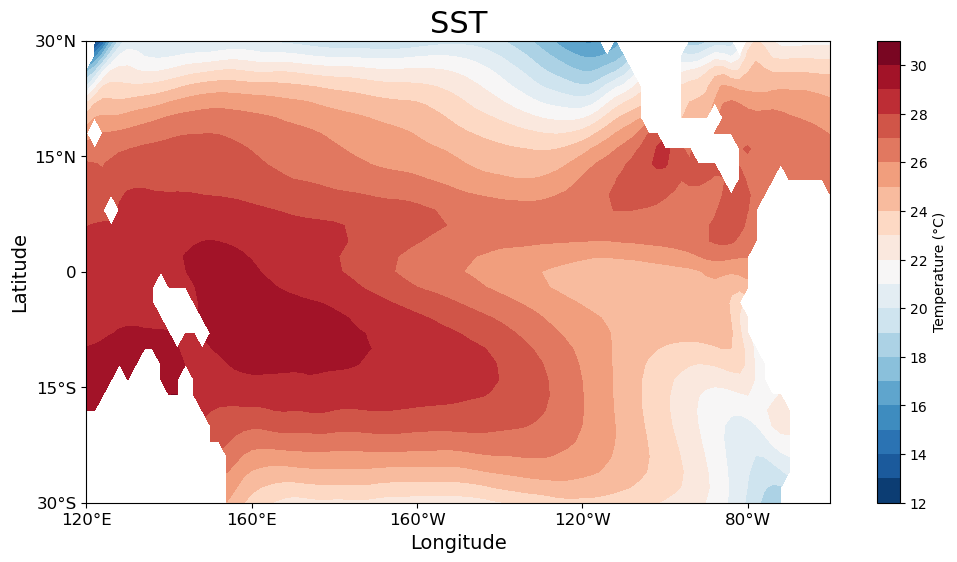

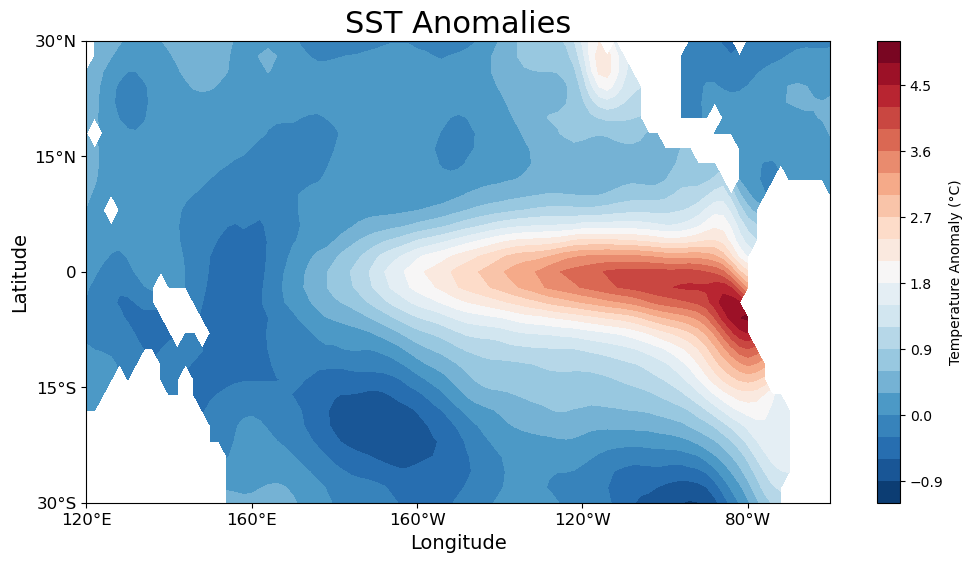

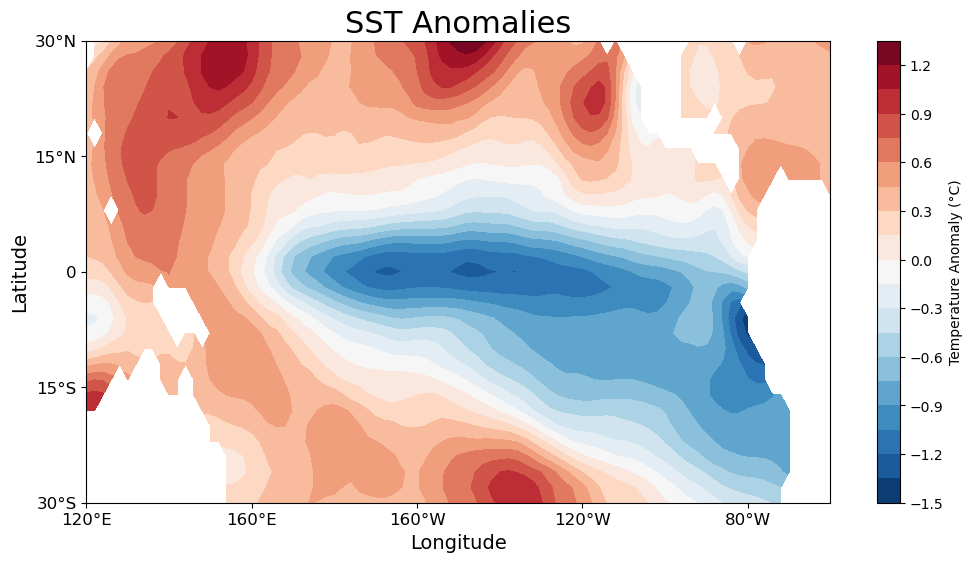

Wind Time range: 1948-01-01 00:00:00 to 2024-10-01 00:00:00
Wind Time steps: 922
El Niño Anomalies Data Shape: (94, 192)
Wind Stress Anomalies for El Niño (Dec 1997) - Max: 0.26033568382263184, Min: -0.11786214262247086


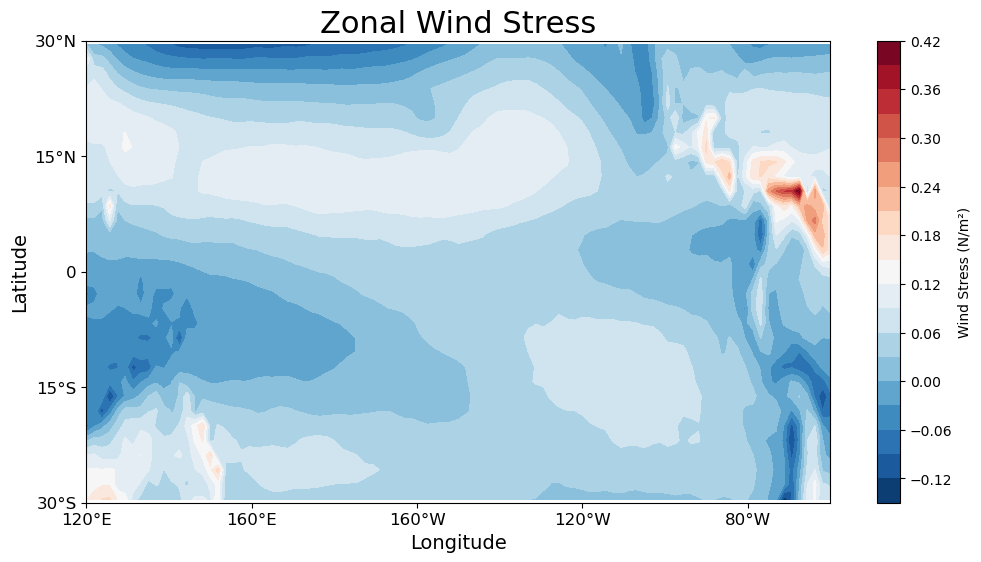

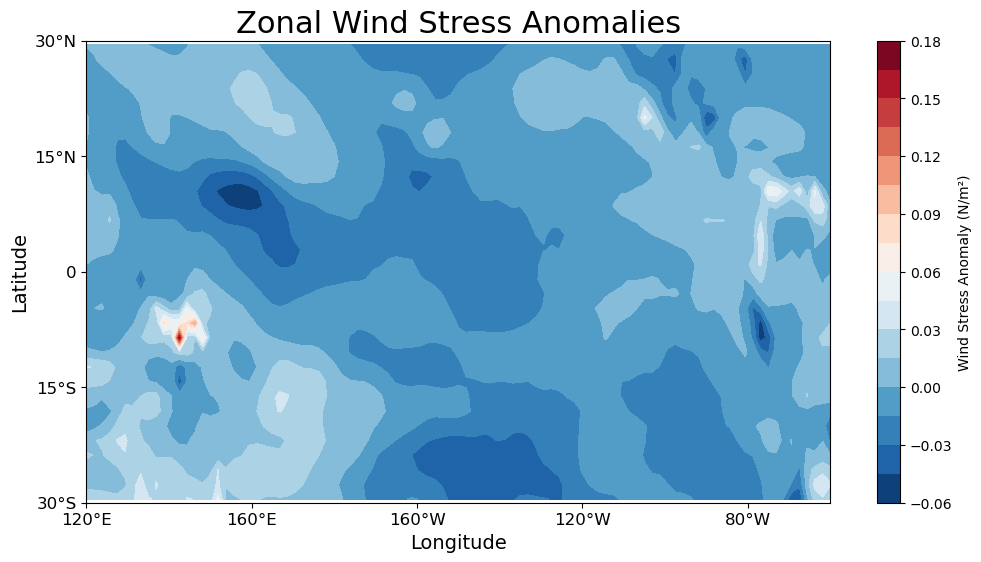

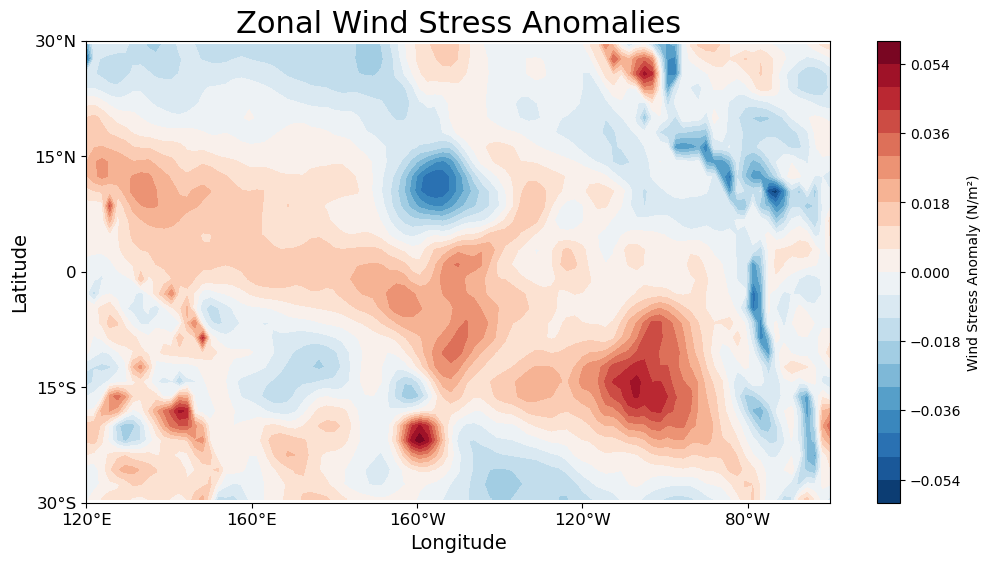

In [19]:

# Define Pacific Ocean region limits
lat_bounds = (-30, 30)  # Latitude range for the Pacific
lon_bounds = (120, 300)  # Longitude range (120°E to 60°W converted to 0–360°)
label_fontsize = 14  # Font size for labels
tick_fontsize = 12  # Font size for tick labels
head_fontsize = 22

def plot_pacific(data, latitudes, longitudes, title, event, colorbar_label, cmap, levels=20):
    # Mask data to only include the Pacific Ocean region
    lat_mask = (latitudes >= lat_bounds[0]) & (latitudes <= lat_bounds[1])
    lon_mask = (longitudes >= lon_bounds[0]) & (longitudes <= lon_bounds[1])
    lat_indices = np.where(lat_mask)[0]
    lon_indices = np.where(lon_mask)[0]
     # Adjust indexing based on the dimensionality of the data
    if data.ndim == 3:  # 3D array: (time, lat, lon)
        pacific_data = data[:, lat_indices, :][:, :, lon_indices]
    elif data.ndim == 2:  # 2D array: (lat, lon)
        pacific_data = data[lat_indices, :][:, lon_indices]
    else:
        raise ValueError(f"Unexpected data dimensions: {data.ndim}")

    pacific_lats = latitudes[lat_indices]
    pacific_lons = longitudes[lon_indices]

    # Create plot
    plt.figure(figsize=(12, 6))
    plt.contourf(pacific_lons, pacific_lats, pacific_data, cmap=cmap, levels=levels)
    plt.colorbar(label=colorbar_label)
    plt.xlabel('Longitude', fontsize = label_fontsize)
    plt.xticks([120, 160, 200, 240, 280],["120°E", "160°E", "160°W", "120°W","80°W"], fontsize = tick_fontsize)
    plt.ylabel('Latitude', fontsize = label_fontsize)
    plt.yticks([-30, -15, 0, 15, 30], ["30°S", "15°S", "0", "15°N","30°N"], fontsize = tick_fontsize)
    
    plt.title(title, fontsize = head_fontsize)
    plt.savefig(f"Figures/{title} {event}.pdf", format ="pdf", bbox_inches ='tight')
    plt.show()

# Load and process SST data
with nc.Dataset('Data/Data Process/sst_with_anomalies.nc', 'r') as sst_nc:
    latitudes = sst_nc.variables['lat'][:]
    longitudes = sst_nc.variables['lon'][:]
    time_var = sst_nc.variables['time']
    time = nc.num2date(time_var[:], units=time_var.units)

    # Variables
    sst_data = sst_nc.variables['sst'][:]  # Original SST
    sst_anomalies = sst_nc.variables['sst_rolling_anomaly'][:]  # SST anomalies
    print(f"Latitude shape: {latitudes.shape}")
    print(f"Longitude shape: {longitudes.shape}")
    print(f"SST data shape: {sst_data.shape}")
    print(f"SST anomalies shape: {sst_anomalies.shape}")


    # Long-term mean for January
    jan_indices = [i for i, t in enumerate(time) if t.month == 1]
    jan_mean = np.mean(sst_data[jan_indices, :, :], axis=0)

    # SST anomalies for December 1997 (El Niño peak)
    el_nino_index = [i for i, t in enumerate(time) if t.year == 1997 and t.month == 11][0]
    el_nino_anomalies = sst_anomalies[el_nino_index, :, :]

    # SST anomalies for November 2020 (La Niña peak)
    la_nina_index = [i for i, t in enumerate(time) if t.year == 2020 and t.month == 11][0]
    la_nina_anomalies = sst_anomalies[la_nina_index, :, :]

    # Plot long-term January mean
    plot_pacific(jan_mean, latitudes, longitudes, 
                 title='SST', 
                 event = "",
                 colorbar_label='Temperature (°C)', cmap='RdBu_r')

    # Plot El Niño anomalies
    plot_pacific(el_nino_anomalies, latitudes, longitudes, 
                 title='SST Anomalies', 
                 event = "El Nino",
                 colorbar_label='Temperature Anomaly (°C)', cmap='RdBu_r')

    # Plot La Niña anomalies
    plot_pacific(la_nina_anomalies, latitudes, longitudes, 
                 title='SST Anomalies',
                 event = "La Nina",
                 colorbar_label='Temperature Anomaly (°C)', cmap='RdBu_r')

# Load and process wind stress data
with nc.Dataset('Data/Data Process/wind_stress_with_anomalies.nc', 'r') as wind_nc:
    latitudes = wind_nc.variables['lat'][:]
    longitudes = wind_nc.variables['lon'][:]
    time_var = wind_nc.variables['time']
    time = nc.num2date(time_var[:], units=time_var.units)
    print(f"Wind Time range: {time[0]} to {time[-1]}")
    print(f"Wind Time steps: {len(time)}")

    # Variables
    wind_stress = wind_nc.variables['uflx'][:]  # Original wind stress
    wind_anomalies = wind_nc.variables['uflx_rolling_anomaly'][:]  # Wind stress anomalies

    # Long-term mean for January
    jan_indices = [i for i, t in enumerate(time) if t.month == 1]
    wind_jan_mean = np.mean(wind_stress[jan_indices, :, :], axis=0)
    el_nino_index = [i for i, t in enumerate(time) if t.year == 1997 and t.month == 7][0]

    la_nina_index = [i for i, t in enumerate(time) if t.year == 2020 and t.month == 7][0]



    # Wind anomalies for December 1997 (El Niño peak)
    wind_el_nino_anomalies = wind_anomalies[el_nino_index, :, :]
    print(f"El Niño Anomalies Data Shape: {wind_el_nino_anomalies.shape}")
    print(f"Wind Stress Anomalies for El Niño (Dec 1997) - Max: {np.max(wind_el_nino_anomalies)}, Min: {np.min(wind_el_nino_anomalies)}")

    # Wind anomalies for November 2020 (La Niña peak)
    wind_la_nina_anomalies = wind_anomalies[la_nina_index, :, :]

    # Plot long-term January mean
    plot_pacific(wind_jan_mean, latitudes, longitudes, 
                 title='Zonal Wind Stress', 
                 event = "",
                 colorbar_label='Wind Stress (N/m²)', cmap='RdBu_r')

    # Plot El Niño anomalies
    plot_pacific(wind_el_nino_anomalies, latitudes, longitudes, 
                 title='Zonal Wind Stress Anomalies', 
                 event = "El Nino",
                 colorbar_label='Wind Stress Anomaly (N/m²)', cmap='RdBu_r')

    # Plot La Niña anomalies
    plot_pacific(wind_la_nina_anomalies, latitudes, longitudes, 
                 title='Zonal Wind Stress Anomalies', 
                 event = "La Nina",
                 colorbar_label='Wind Stress Anomaly (N/m²)', cmap='RdBu_r')


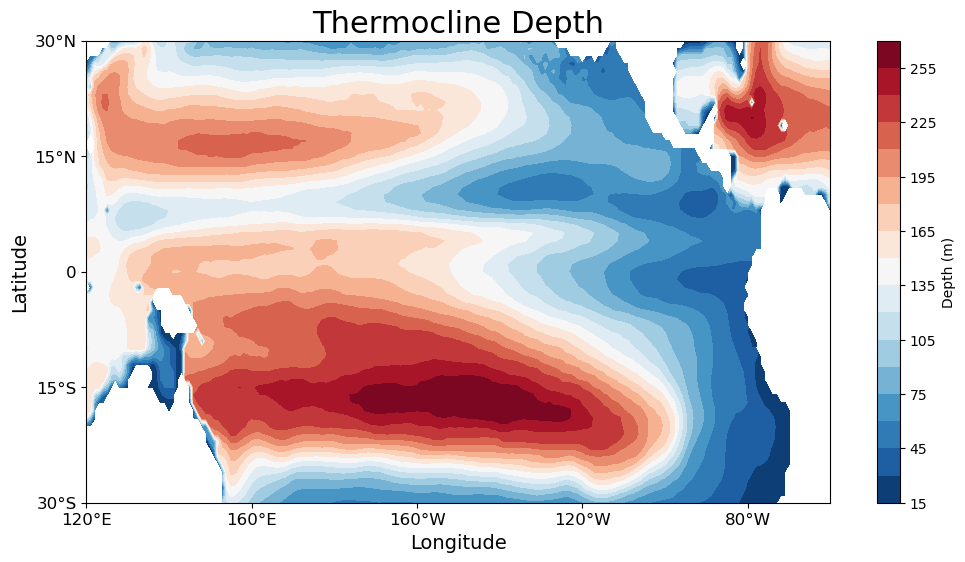

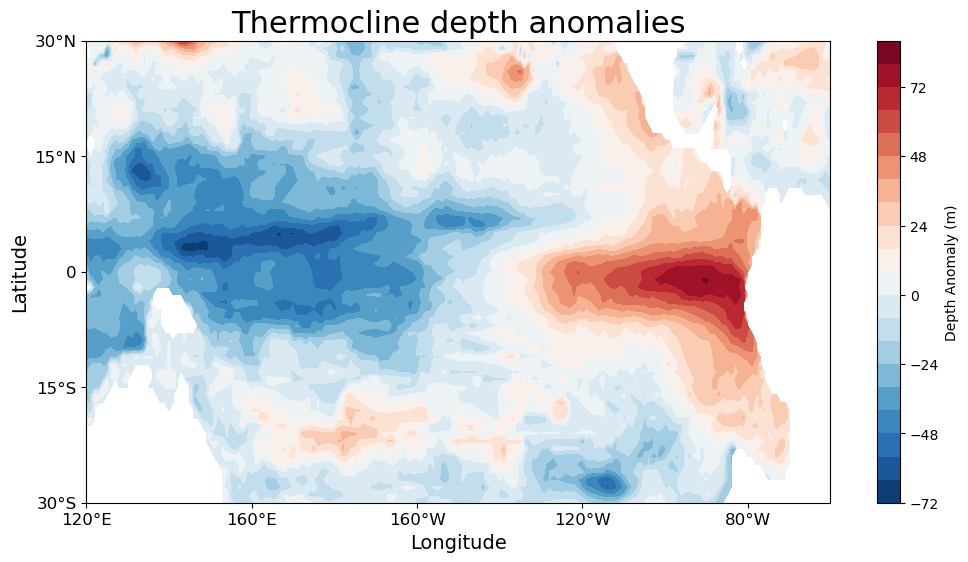

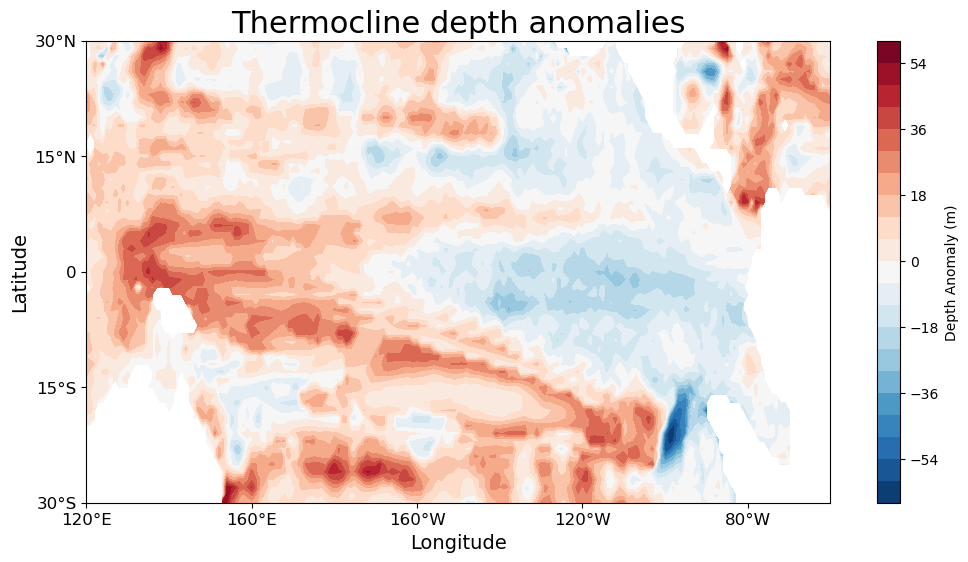

In [20]:


# Define Pacific Ocean region limits
lat_bounds = (-30, 30)  # Latitude range for the Pacific
lon_bounds = (120, 300)  # Longitude range (0–360 format)

def plot_pacific(data, latitudes, longitudes, title, event, colorbar_label, cmap, levels=20):
    # Mask data to only include the Pacific Ocean region
    lat_mask = (latitudes >= lat_bounds[0]) & (latitudes <= lat_bounds[1])
    lon_mask = (longitudes >= lon_bounds[0]) & (longitudes <= lon_bounds[1])
    lat_indices = np.where(lat_mask)[0]
    lon_indices = np.where(lon_mask)[0]

    # Extract Pacific data
    pacific_data = data[:, lat_indices, :][:, :, lon_indices] if data.ndim == 3 else data[lat_indices, :][:, lon_indices]
    pacific_lats = latitudes[lat_indices]
    pacific_lons = longitudes[lon_indices]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.contourf(pacific_lons, pacific_lats, pacific_data, cmap=cmap, levels=levels)
    plt.colorbar(label=colorbar_label)
    plt.xlabel('Longitude', fontsize = label_fontsize)
    plt.xticks([120, 160, 200, 240, 280],["120°E", "160°E", "160°W", "120°W","80°W"], fontsize = tick_fontsize)
    plt.ylabel('Latitude', fontsize = label_fontsize)
    plt.yticks([-30, -15, 0, 15, 30], ["30°S", "15°S", "0", "15°N","30°N"], fontsize = tick_fontsize)
    
    plt.title(title, fontsize = head_fontsize)
    plt.savefig(f"Figures/{title} {event}.pdf", format ="pdf", bbox_inches ='tight')
    plt.show()

# Load and process z20 dataset
with nc.Dataset('Data/Data Process/z20_with_anomalies.nc', 'r') as z20_nc:
    # Load variables
    time_var = z20_nc.variables['time']
    time = nc.num2date(time_var[:], units=time_var.units)
    latitudes = z20_nc.variables['lat'][:]
    longitudes = z20_nc.variables['lon'][:]
    z20_data = z20_nc.variables['z20_depth'][:]  # Original z20 depth
    z20_anomalies = z20_nc.variables['z20_depth_rolling_anomaly'][:]  # z20 anomalies

    # Long-term mean for January
    jan_indices = [i for i, t in enumerate(time) if t.month == 1]
    z20_jan_mean = np.mean(z20_data[jan_indices, :, :], axis=0)

    # Anomalies for December 1997 (El Niño peak)
    el_nino_index = [i for i, t in enumerate(time) if t.year == 1997 and t.month == 12][0]
    z20_el_nino_anomalies = z20_anomalies[el_nino_index, :, :]

    # Anomalies for November 2020 (La Niña peak)
    la_nina_index = [i for i, t in enumerate(time) if t.year == 2020 and t.month == 12][0]
    z20_la_nina_anomalies = z20_anomalies[la_nina_index, :, :]

    # Plot long-term January mean
    plot_pacific(z20_jan_mean, latitudes, longitudes, 
                 title='Thermocline Depth', 
                 event = "",
                 colorbar_label='Depth (m)', cmap='RdBu_r')

    # Plot El Niño anomalies
    plot_pacific(z20_el_nino_anomalies, latitudes, longitudes, 
                 title='Thermocline depth anomalies', 
                 event = "El Niño",
                 colorbar_label='Depth Anomaly (m)', cmap='RdBu_r')

    # Plot La Niña anomalies
    plot_pacific(z20_la_nina_anomalies, latitudes, longitudes, 
                 title='Thermocline depth anomalies', 
                 event = "La Niña",
                 colorbar_label='Depth Anomaly (m)', cmap='RdBu_r')


### Hovmöller Diagrams

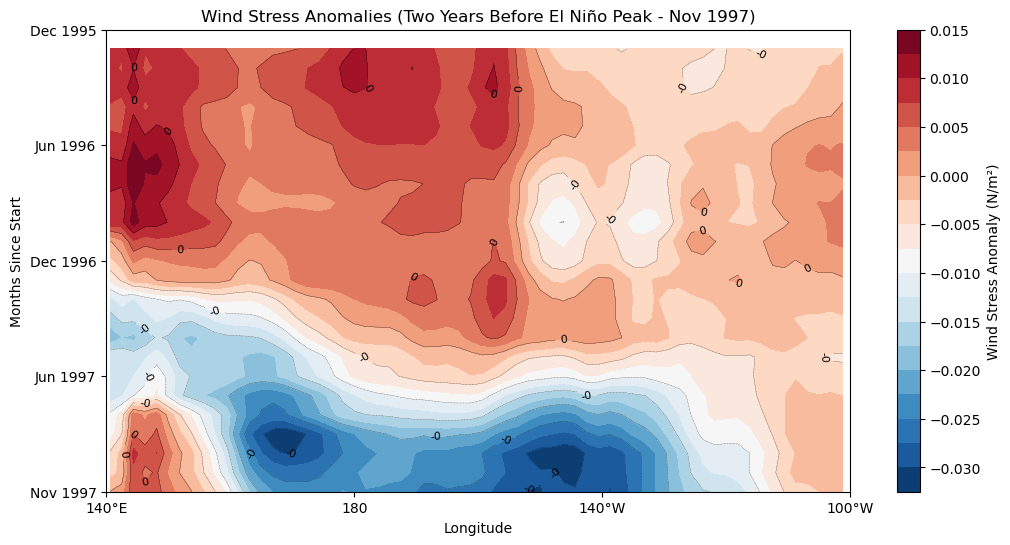

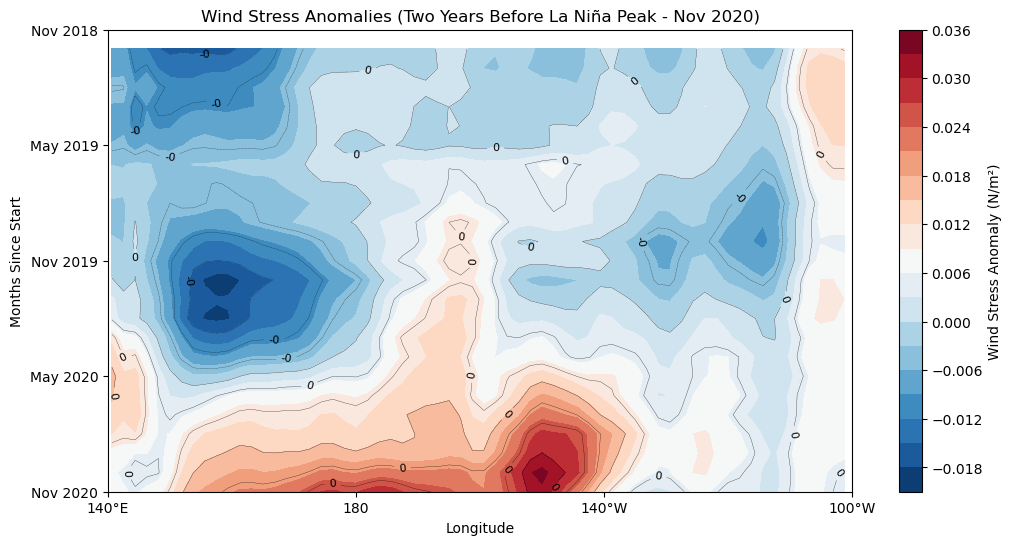

In [21]:
from datetime import datetime, timedelta
# Define Pacific Ocean region limits
lat_bounds = (-5, 5)  # Latitude range for the Pacific
lon_bounds = (140, 260)  # Longitude range for Pacific Ocean (in 0–360 format)

# Load and process Wind Stress anomalies dataset
with nc.Dataset('Data/Data Process/wind_stress_with_anomalies.nc', 'r') as wind_nc:
    # Load variables
    time_var = wind_nc.variables['time']
    time = nc.num2date(time_var[:], units=time_var.units)  # Keep as datetime.datetime or cftime objects
    latitudes = wind_nc.variables['lat'][:]
    longitudes = wind_nc.variables['lon'][:]
    wind_anomalies = wind_nc.variables['uflx_rolling_anomaly'][:]  # Shape: (time, lat, lon)

    # Mask latitudes for the equatorial Pacific (5°N–5°S)
    lat_mask = (latitudes >= lat_bounds[0]) & (latitudes <= lat_bounds[1])
    equatorial_wind = np.mean(wind_anomalies[:, lat_mask, :], axis=1)  # Average over latitudes

    # Mask longitudes for the Pacific region (120°E–300°E)
    lon_mask = (longitudes >= lon_bounds[0]) & (longitudes <= lon_bounds[1])
    pacific_wind = equatorial_wind[:, lon_mask]  # Restrict data to Pacific region
    pacific_longitudes = longitudes[lon_mask]

    # Define time range for two years before December 1997 (El Niño)
    el_nino_peak = datetime(1997, 11, 1)  # Use datetime.datetime objects
    start_time_el_nino = el_nino_peak - timedelta(days=730)  # Start two years earlier

    # Create a time mask for El Niño
    el_nino_time_mask = [(t >= start_time_el_nino) and (t <= el_nino_peak) for t in time]
    el_nino_time_indices = np.where(el_nino_time_mask)[0]

    # Convert times to months relative to the start of the range
    el_nino_selected_time = np.array(time)[el_nino_time_indices]
    months_since_start = [
        (t.year - start_time_el_nino.year) * 12 + (t.month - start_time_el_nino.month)
        for t in el_nino_selected_time
    ]

    # Select data for the time range
    el_nino_selected_wind = pacific_wind[el_nino_time_indices, :]

    # Plot the Hovmöller diagram for two years before El Niño
    plt.figure(figsize=(12, 6))
    contourf_plot = plt.contourf(
        pacific_longitudes, 
        months_since_start, 
        el_nino_selected_wind, 
        cmap='RdBu_r', 
        levels=20
    )
    plt.colorbar(label='Wind Stress Anomaly (N/m²)')


    # Add contour lines
    contour_lines = plt.contour(
        pacific_longitudes, 
        months_since_start, 
        el_nino_selected_wind, 
        levels=10, 
        colors='k', 
        linewidths=0.2
    )

    # Add labels to the contour lines
    plt.clabel(
        contour_lines, 
        inline=True,  # Draw labels on the contour lines
        fontsize=8,   # Font size for the labels
        fmt='%1.0f'   # Label format (integer values)
    )
    # Add axis labels and title
    plt.xlabel('Longitude')
    plt.xticks([140, 180, 220, 260], ['140°E', '180', '140°W', '100°W'])
    plt.ylabel('Months Since Start')

    # Update y-axis labels to show real dates
    plt.gca().set_yticks([0, 6, 12, 18, 24])  # Set tick locations
    plt.gca().set_yticklabels(['Dec 1995', 'Jun 1996', 'Dec 1996', 'Jun 1997', 'Nov 1997'])  # Custom labels
    plt.title('Wind Stress Anomalies (Two Years Before El Niño Peak - Nov 1997)')
    plt.gca().invert_yaxis()  # Optional: invert time axis
    plt.show()

    # Define time range for two years before November 2020 (La Niña)
    la_nina_peak = datetime(2020, 11, 1)
    start_time_la_nina = la_nina_peak - timedelta(days=730)

    # Create a time mask for La Niña
    la_nina_time_mask = [(t >= start_time_la_nina) and (t <= la_nina_peak) for t in time]
    la_nina_time_indices = np.where(la_nina_time_mask)[0]

    # Convert times to months relative to the start of the range
    la_nina_selected_time = np.array(time)[la_nina_time_indices]
    months_since_start = [
        (t.year - start_time_la_nina.year) * 12 + (t.month - start_time_la_nina.month)
        for t in la_nina_selected_time
    ]

    # Select data for the time range
    la_nina_selected_wind = pacific_wind[la_nina_time_indices, :]

    # Plot the Hovmöller diagram for two years before La Niña
    plt.figure(figsize=(12, 6))
    contourf_plot = plt.contourf(
        pacific_longitudes, 
        months_since_start, 
        la_nina_selected_wind, 
        cmap='RdBu_r', 
        levels=20
    )
    plt.colorbar(label='Wind Stress Anomaly (N/m²)')


    # Add contour lines
    contour_lines = plt.contour(
        pacific_longitudes, 
        months_since_start, 
        la_nina_selected_wind, 
        levels=10, 
        colors='k', 
        linewidths=0.2
    )

    # Add labels to the contour lines
    plt.clabel(
        contour_lines, 
        inline=True,  # Draw labels on the contour lines
        fontsize=8,   # Font size for the labels
        fmt='%1.0f'   # Label format (integer values)
    )
    # 
    # Add axis labels and title
    plt.xlabel('Longitude')
    plt.xticks([140, 180, 220, 260], ['140°E', '180', '140°W', '100°W'])
    plt.ylabel('Months Since Start')

    # Update y-axis labels to show real dates
    plt.gca().set_yticks([0, 6, 12, 18, 24])  # Set tick locations
    plt.gca().set_yticklabels(['Nov 2018', 'May 2019', 'Nov 2019', 'May 2020', 'Nov 2020'])  # Custom labels
    plt.title('Wind Stress Anomalies (Two Years Before La Niña Peak - Nov 2020)')
    plt.gca().invert_yaxis()  # Optional: invert time axis
    plt.show()




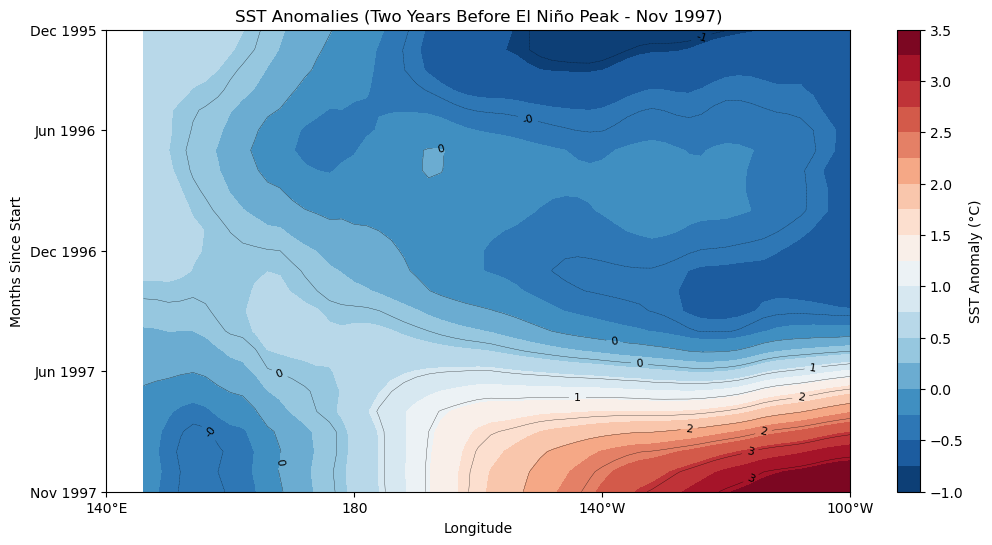

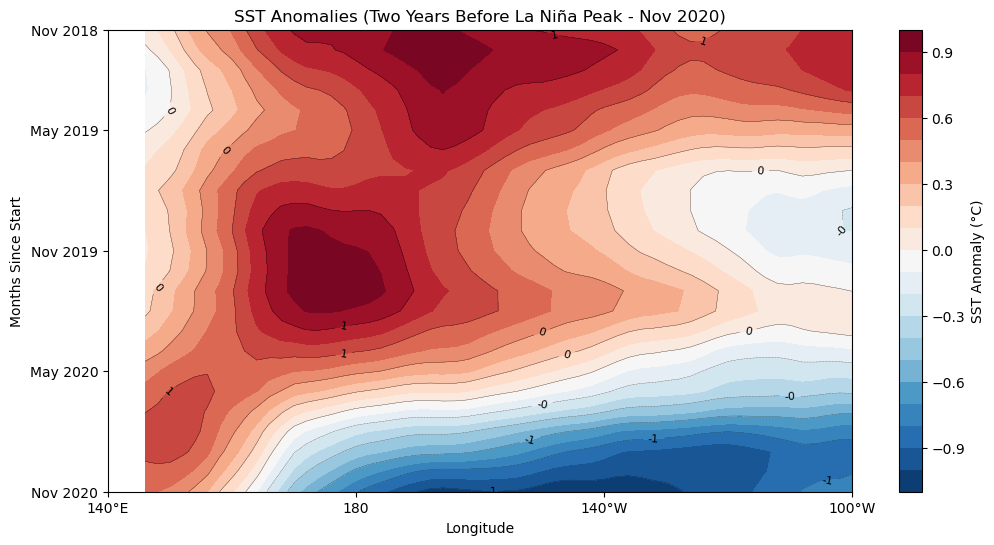

In [22]:

# Define latitude and longitude bounds for the equatorial Pacific
lat_bounds = (-5, 5)  # Latitude range for equatorial Pacific
lon_bounds = (140, 260)  # Longitude range for Pacific Ocean (in 0–360 format)

# Load and process SST anomalies dataset
with nc.Dataset('Data/Data Process/sst_with_anomalies.nc', 'r') as sst_nc:
    # Load variables
    time_var = sst_nc.variables['time']
    time = nc.num2date(time_var[:], units=time_var.units)  # Keep as datetime.datetime or cftime objects
    latitudes = sst_nc.variables['lat'][:]
    longitudes = sst_nc.variables['lon'][:]
    sst_anomalies = sst_nc.variables['sst_rolling_anomaly'][:]  # Shape: (time, lat, lon)

    # Mask latitudes for the equatorial Pacific (5°N–5°S)
    lat_mask = (latitudes >= lat_bounds[0]) & (latitudes <= lat_bounds[1])
    equatorial_sst = np.mean(sst_anomalies[:, lat_mask, :], axis=1)  # Average over latitudes

    # Mask longitudes for the Pacific region (120°E–300°E)
    lon_mask = (longitudes >= lon_bounds[0]) & (longitudes <= lon_bounds[1])
    pacific_sst = equatorial_sst[:, lon_mask]  # Restrict data to Pacific region
    pacific_longitudes = longitudes[lon_mask]

    ### El Niño Event ###
    # Define time range for two years before December 1997
    el_nino_peak = datetime(1997, 11, 1)  # El Niño peak
    start_time_el_nino = el_nino_peak - timedelta(days=730)  # Start two years earlier

    # Create a time mask for El Niño
    el_nino_time_mask = [(t >= start_time_el_nino) and (t <= el_nino_peak) for t in time]
    el_nino_time_indices = np.where(el_nino_time_mask)[0]

    # Convert times to months relative to the start of the range
    el_nino_selected_time = np.array(time)[el_nino_time_indices]
    months_since_start = [
        (t.year - start_time_el_nino.year) * 12 + (t.month - start_time_el_nino.month)
        for t in el_nino_selected_time
    ]

    # Select data for the time range
    el_nino_selected_sst = pacific_sst[el_nino_time_indices, :]

    # Plot the Hovmöller diagram for two years before El Niño
    plt.figure(figsize=(12, 6))
    contourf_plot = plt.contourf(
        pacific_longitudes, 
        months_since_start, 
        el_nino_selected_sst, 
        cmap='RdBu_r', 
        levels=20
    )
    plt.colorbar(label='SST Anomaly (°C)')


    # Add contour lines
    contour_lines = plt.contour(
        pacific_longitudes, 
        months_since_start, 
        el_nino_selected_sst, 
        levels=10, 
        colors='k', 
        linewidths=0.2
    )

    # Add labels to the contour lines
    plt.clabel(
        contour_lines, 
        inline=True,  # Draw labels on the contour lines
        fontsize=8,   # Font size for the labels
        fmt='%1.0f'   # Label format (integer values)
    )
    # Add axis labels and title
    plt.xlabel('Longitude')
    plt.xticks([140, 180, 220, 260], ['140°E', '180', '140°W', '100°W'])
    plt.ylabel('Months Since Start')

    # Update y-axis labels to show real dates
    plt.gca().set_yticks([1, 6, 12, 18, 24])  # Set tick locations
    plt.gca().set_yticklabels(['Dec 1995', 'Jun 1996', 'Dec 1996', 'Jun 1997', 'Nov 1997'])  # Custom labels
    plt.title('SST Anomalies (Two Years Before El Niño Peak - Nov 1997)')
    plt.gca().invert_yaxis()  # Optional: invert time axis
    plt.show()

    ### La Niña Event ###
    # Define time range for two years before November 2020
    la_nina_peak = datetime(2020, 11, 1)  # La Niña peak
    start_time_la_nina = la_nina_peak - timedelta(days=730)

    # Create a time mask for La Niña
    la_nina_time_mask = [(t >= start_time_la_nina) and (t <= la_nina_peak) for t in time]
    la_nina_time_indices = np.where(la_nina_time_mask)[0]

    # Convert times to months relative to the start of the range
    la_nina_selected_time = np.array(time)[la_nina_time_indices]
    months_since_start = [
        (t.year - start_time_la_nina.year) * 12 + (t.month - start_time_la_nina.month)
        for t in la_nina_selected_time
    ]

    # Select data for the time range
    la_nina_selected_sst = pacific_sst[la_nina_time_indices, :]

    # Plot the Hovmöller diagram for two years before La Niña
    plt.figure(figsize=(12, 6))
    # Filled contours (color map)
    contourf_plot = plt.contourf(
        pacific_longitudes, 
        months_since_start, 
        la_nina_selected_sst, 
        cmap='RdBu_r', 
        levels=20
    )
    plt.colorbar(label='SST Anomaly (°C)')


    # Add contour lines
    contour_lines = plt.contour(
        pacific_longitudes, 
        months_since_start, 
        la_nina_selected_sst, 
        levels=10, 
        colors='k', 
        linewidths=0.2
    )

    # Add labels to the contour lines
    plt.clabel(
        contour_lines, 
        inline=True,  # Draw labels on the contour lines
        fontsize=8,   # Font size for the labels
        fmt='%1.0f'   # Label format (integer values)
    )

    # Add axis labels and title
    plt.xlabel('Longitude')
    plt.xticks([140, 180, 220, 260], ['140°E', '180', '140°W', '100°W'])
    plt.ylabel('Months Since Start')

    # Update y-axis labels to show real dates
    plt.gca().set_yticks([1, 6, 12, 18, 24])  # Set tick locations
    plt.gca().set_yticklabels(['Nov 2018', 'May 2019', 'Nov 2019', 'May 2020', 'Nov 2020'])  # Custom labels
    plt.title('SST Anomalies (Two Years Before La Niña Peak - Nov 2020)')
    plt.gca().invert_yaxis()  # Optional: invert time axis
    plt.show()



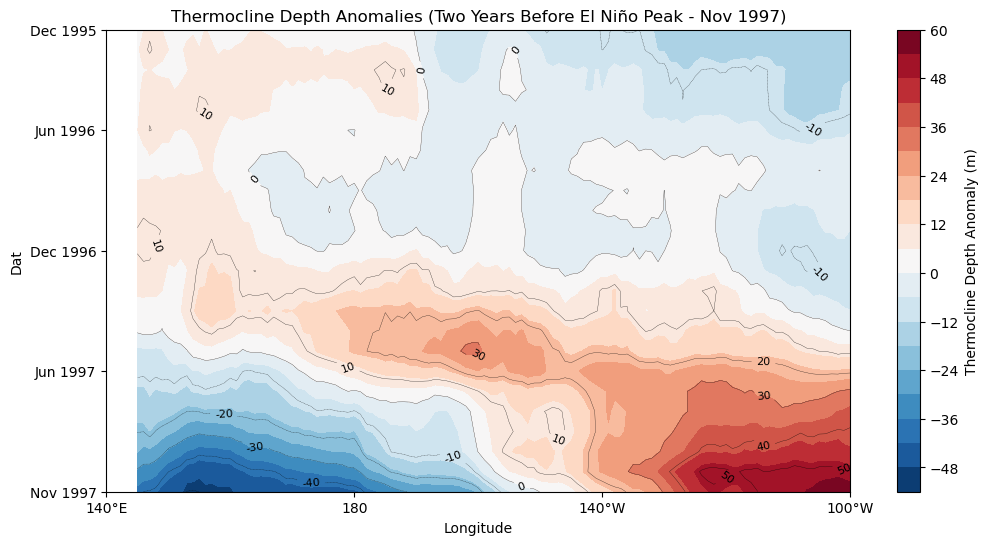

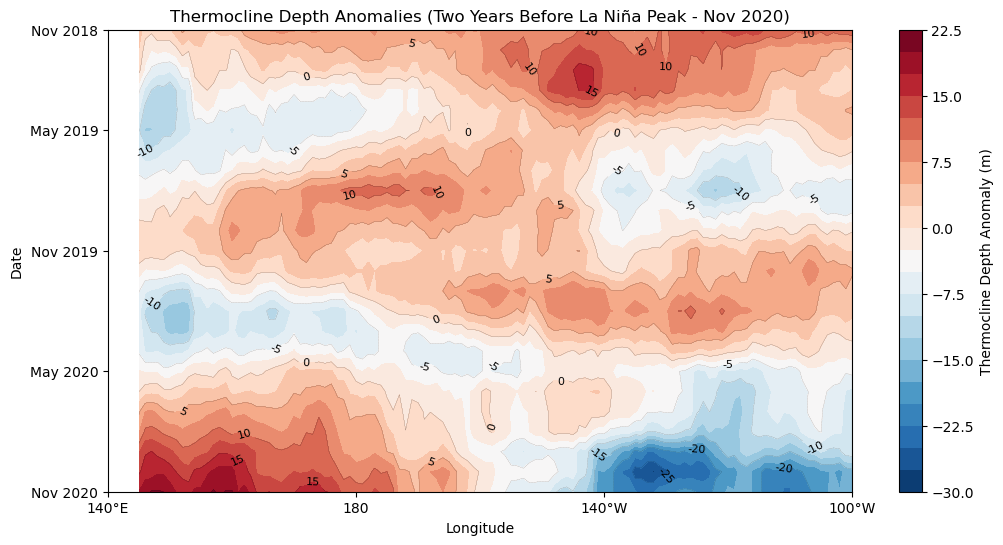

In [23]:

# Load and process Thermocline Depth anomalies dataset
with nc.Dataset('Data/Data Process/z20_with_anomalies.nc', 'r') as z20_nc:
    # Load variables
    time_var = z20_nc.variables['time']
    time = nc.num2date(time_var[:], units=time_var.units)  # Keep time as datetime-compatible objects
    latitudes = z20_nc.variables['lat'][:]
    longitudes = z20_nc.variables['lon'][:]
    z20_anomalies = z20_nc.variables['z20_depth_rolling_anomaly'][:]  # Shape: (time, lat, lon)

    # Mask latitudes for the equatorial Pacific (5°N–5°S)
    lat_mask = (latitudes >= lat_bounds[0]) & (latitudes <= lat_bounds[1])
    equatorial_z20 = np.mean(z20_anomalies[:, lat_mask, :], axis=1)  # Average over latitudes

    # Mask longitudes for the Pacific region (120°E–300°E)
    lon_mask = (longitudes >= lon_bounds[0]) & (longitudes <= lon_bounds[1])
    pacific_z20 = equatorial_z20[:, lon_mask]  # Restrict data to Pacific region
    pacific_longitudes = longitudes[lon_mask]

    ### El Niño Event ###
    # Define time range for two years before December 1997
    el_nino_peak = datetime(1997, 11, 16)  # El Niño peak
    start_time_el_nino = el_nino_peak - timedelta(days=730)  # Subtract two years

    el_nino_time_mask = [(t >= start_time_el_nino) and (t <= el_nino_peak) for t in time]
    el_nino_time_indices = np.where(el_nino_time_mask)[0]

    # Select data for the time range
    el_nino_selected_time = np.array(time)[el_nino_time_indices]

    # Convert times to months since the start of the range
    months_since_start = [
        (t.year - start_time_el_nino.year) * 12 + (t.month - start_time_el_nino.month)
        for t in el_nino_selected_time
    ]
    el_nino_selected_z20 = pacific_z20[el_nino_time_indices, :]
        ### La Niña Event ###
    # Define time range for two years before November 2020
    la_nina_peak = datetime(2020, 11, 16)  # La Niña peak
    start_time_la_nina = la_nina_peak - timedelta(days=730)  # Subtract two years

    la_nina_time_mask = [(t >= start_time_la_nina) and (t <= la_nina_peak) for t in time]
    la_nina_time_indices = np.where(la_nina_time_mask)[0]

    # Select data for the time range
    la_nina_selected_time = np.array(time)[la_nina_time_indices]

    # Convert times to months since the start of the range
    months_since_start = [
        (t.year - start_time_la_nina.year) * 12 + (t.month - start_time_la_nina.month)
        for t in la_nina_selected_time
    ]
    la_nina_selected_z20 = pacific_z20[la_nina_time_indices, :]



# Plot the Hovmöller diagram for two years before El Niño
plt.figure(figsize=(12, 6))

# Filled contours (color map)
contourf_plot = plt.contourf(
    pacific_longitudes, 
    months_since_start, 
    el_nino_selected_z20, 
    cmap='RdBu_r', 
    levels=20
)
plt.colorbar(label='Thermocline Depth Anomaly (m)')

# Add contour lines
contour_lines = plt.contour(
    pacific_longitudes, 
    months_since_start, 
    el_nino_selected_z20, 
    levels=10, 
    colors='k', 
    linewidths=0.2
)

# Add labels to the contour lines
plt.clabel(
    contour_lines, 
    inline=True,  # Draw labels on the contour lines
    fontsize=8,   # Font size for the labels
    fmt='%1.0f'   # Label format (integer values)
)

# Add axis labels and title
plt.xlabel('Longitude')
plt.xticks([140, 180, 220, 260], ['140°E', '180', '140°W', '100°W'])
plt.ylabel('Dat')

# Update y-axis labels to show real dates
plt.gca().set_yticks([1, 6, 12, 18, 24])  # Set tick locations
plt.gca().set_yticklabels(['Dec 1995', 'Jun 1996', 'Dec 1996', 'Jun 1997', 'Nov 1997'])  # Custom labels

# Add a title and invert the y-axis (optional)
plt.title('Thermocline Depth Anomalies (Two Years Before El Niño Peak - Nov 1997)')
plt.gca().invert_yaxis()

plt.show()

# Repeat similar steps for the La Niña Event
plt.figure(figsize=(12, 6))

# Filled contours (color map)
contourf_plot = plt.contourf(
    pacific_longitudes, 
    months_since_start, 
    la_nina_selected_z20, 
    cmap='RdBu_r', 
    levels=20
)
plt.colorbar(label='Thermocline Depth Anomaly (m)')

# Add contour lines
contour_lines = plt.contour(
    pacific_longitudes, 
    months_since_start, 
    la_nina_selected_z20, 
    levels=10, 
    colors='k', 
    linewidths=0.1
)

# Add labels to the contour lines
plt.clabel(
    contour_lines, 
    inline=True,  # Draw labels on the contour lines
    fontsize=8,   # Font size for the labels
    fmt='%1.0f'   # Label format (integer values)
)

# Add axis labels and title
plt.xlabel('Longitude')
plt.xticks([140, 180, 220, 260], ['140°E', '180', '140°W', '100°W'])
plt.ylabel('Date')

# Update y-axis labels to show real dates
plt.gca().set_yticks([1, 6, 12, 18, 24])  # Set tick locations
plt.gca().set_yticklabels(['Nov 2018', 'May 2019', 'Nov 2019', 'May 2020', 'Nov 2020'])  # Custom labels

# Add a title and invert the y-axis (optional)
plt.title('Thermocline Depth Anomalies (Two Years Before La Niña Peak - Nov 2020)')
plt.gca().invert_yaxis()

plt.show()


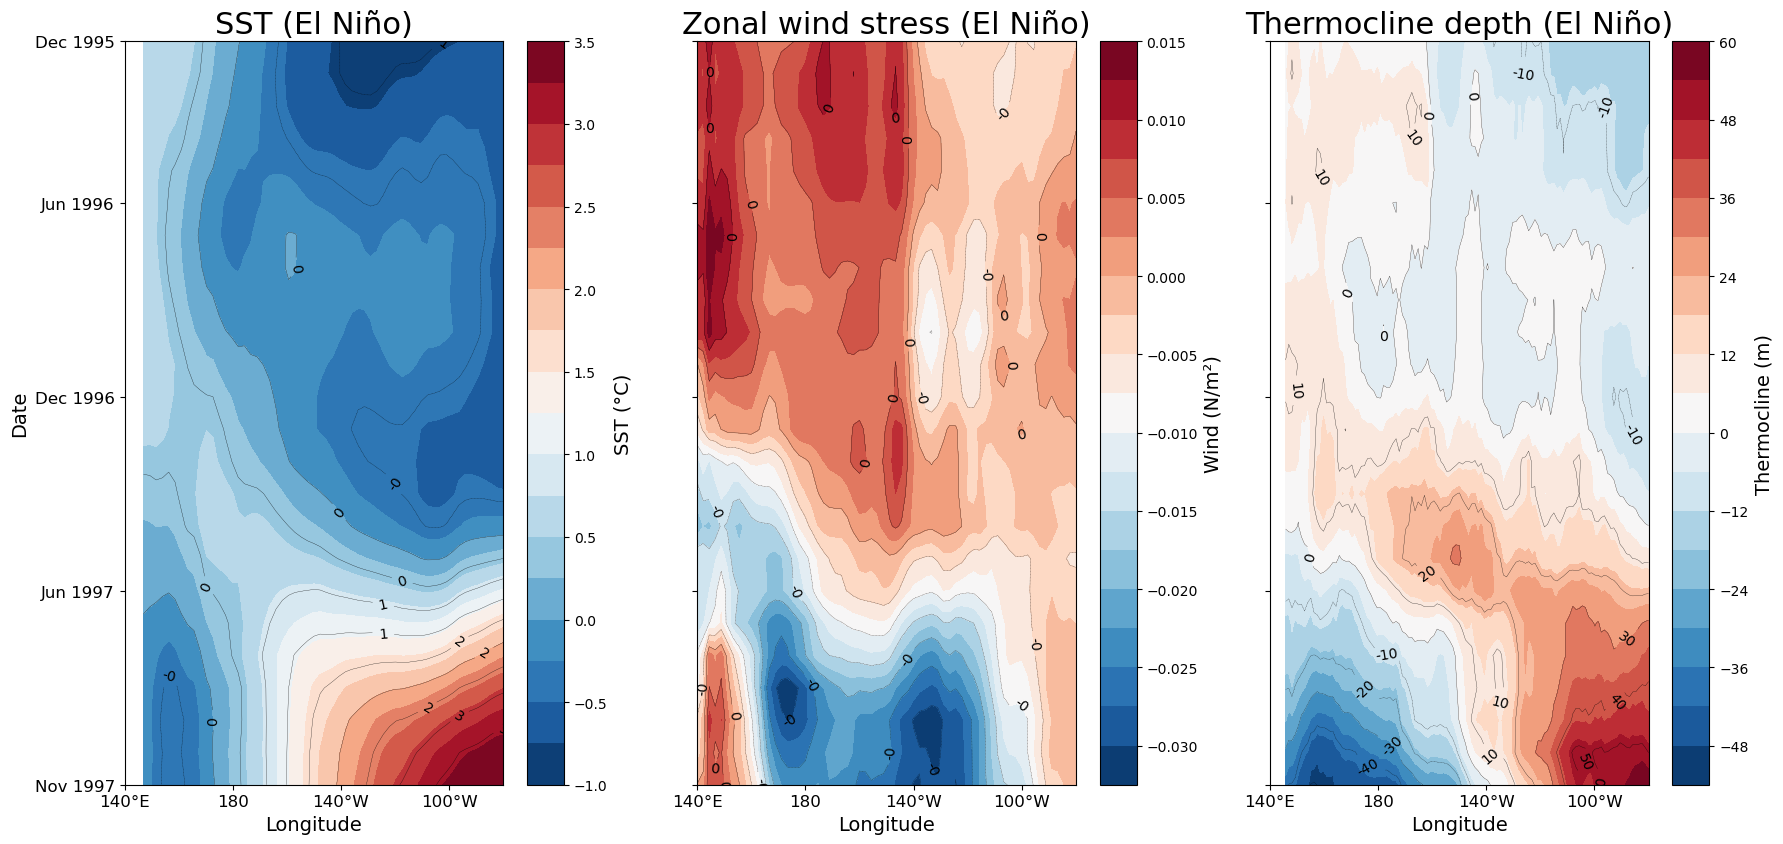

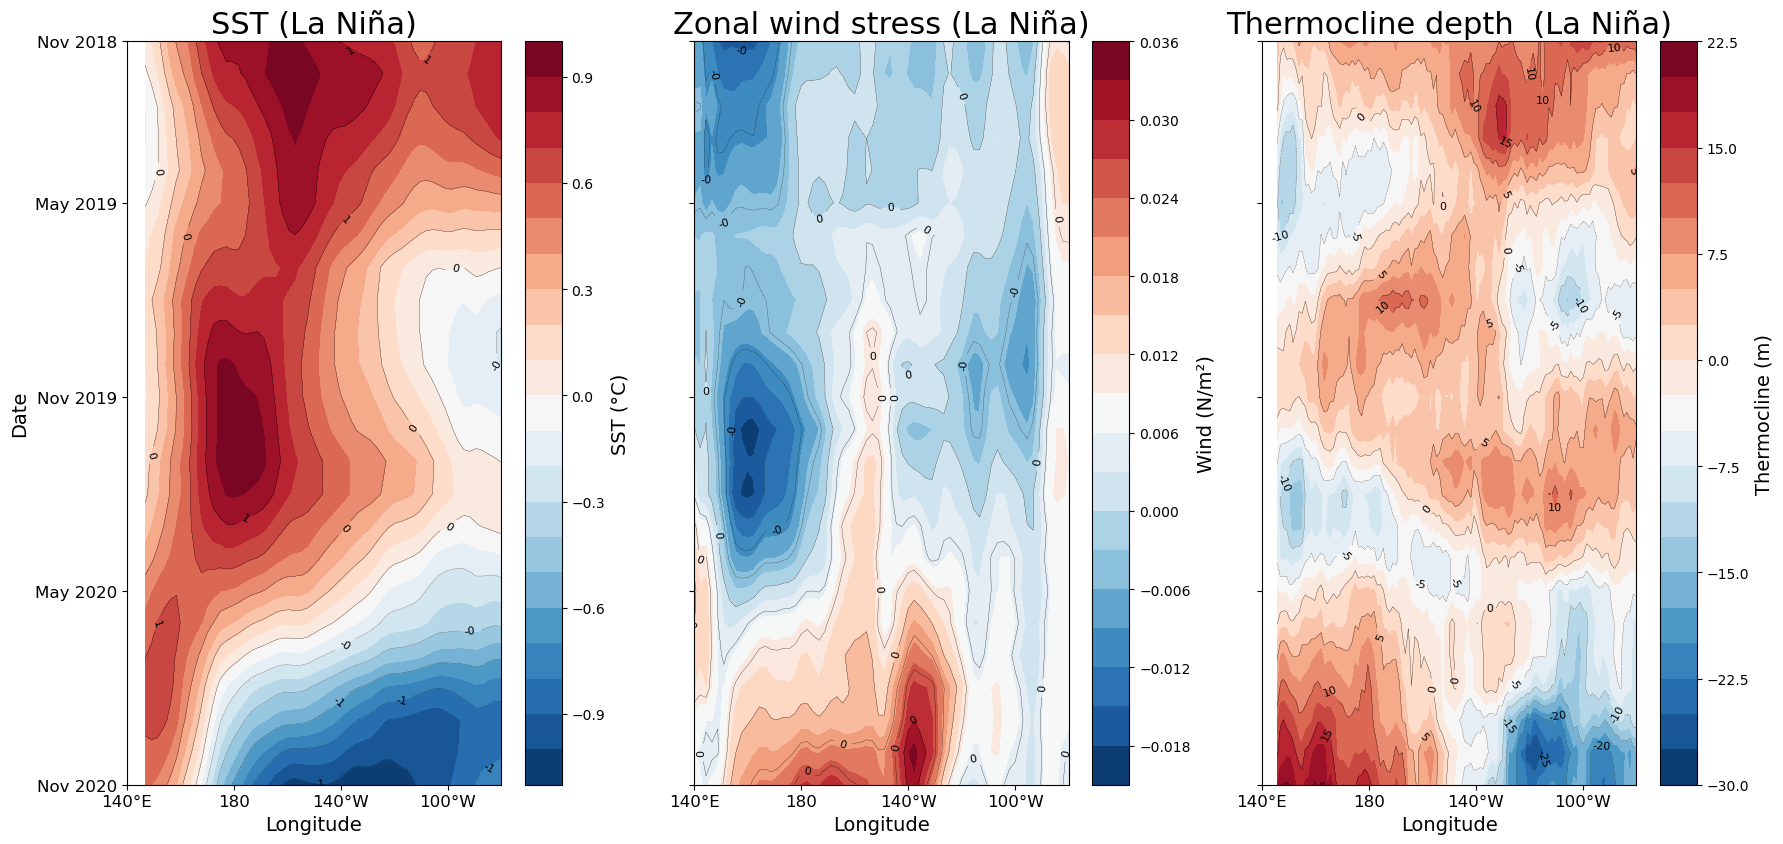

In [24]:
# Correct longitude arrays based on the data shapes
longitudes_sst = np.linspace(140, 280, el_nino_selected_sst.shape[1])  # Matches SST data (71 columns)
longitudes_wind = np.linspace(140, 280, el_nino_selected_wind.shape[1])  # Matches Wind data (75 columns)
longitudes_z20 = np.linspace(140, 280, el_nino_selected_z20.shape[1])  # Matches Thermocline data (141 columns)

# Define subplot layout for El Niño
fig, axes = plt.subplots(1, 3, figsize=(18, 9), sharey=True)
label_fontsize = 14  # Font size for labels
tick_fontsize = 12  # Font size for tick labels

# Data for El Niño plots
datasets_el_nino = [
    (longitudes_sst, months_since_start, el_nino_selected_sst, "SST (°C)", "SST (El Niño)"),
    (longitudes_wind, months_since_start, el_nino_selected_wind, "Wind (N/m²)", "Zonal wind stress (El Niño)"),
    (longitudes_z20, months_since_start, el_nino_selected_z20, "Thermocline (m)", "Thermocline depth (El Niño)")
]

# Create subplots for El Niño
for ax, (longitudes, months, data, colorbar_label, title) in zip(axes, datasets_el_nino):
    contourf_plot = ax.contourf(longitudes, months, data, cmap='RdBu_r', levels=20)
    cbar = plt.colorbar(contourf_plot, ax=ax)
    cbar.set_label(colorbar_label, fontsize=label_fontsize )
    contour_lines = ax.contour(longitudes, months, data, levels=10, colors='k', linewidths=0.2)
    ax.clabel(contour_lines, inline=True, fontsize=10, fmt='%1.0f')
    ax.set_title(title, fontsize = 22)
    ax.set_xlabel('Longitude', fontsize=label_fontsize)
    ax.set_xticks([140, 180, 220, 260], ['140°E', '180', '140°W', '100°W'], fontsize=tick_fontsize)
    ax.invert_yaxis()

axes[0].set_ylabel('Date', fontsize=label_fontsize)
axes[0].set_yticks([1, 6, 12, 18, 24])
axes[0].set_yticklabels(['Dec 1995', 'Jun 1996', 'Dec 1996', 'Jun 1997', 'Nov 1997'], fontsize=tick_fontsize)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Figures/ElNino_hovmollers_diagram.pdf", format ="pdf", bbox_inches ='tight')
plt.show()

# Define subplot layout for La Niña
fig, axes = plt.subplots(1, 3, figsize=(18, 9), sharey=True)

# Data for La Niña plots
datasets_la_nina = [
    (longitudes_sst, months_since_start, la_nina_selected_sst, "SST (°C)", "SST (La Niña)"),
    (longitudes_wind, months_since_start, la_nina_selected_wind, "Wind (N/m²)", "Zonal wind stress (La Niña)"),
    (longitudes_z20, months_since_start, la_nina_selected_z20, "Thermocline (m)", "Thermocline depth  (La Niña)")
]

# Create subplots for La Niña
for ax, (longitudes, months, data, colorbar_label, title) in zip(axes, datasets_la_nina):
    contourf_plot = ax.contourf(longitudes, months, data, cmap='RdBu_r', levels=20)
    cbar = plt.colorbar(contourf_plot, ax=ax)
    cbar.set_label(colorbar_label, fontsize=label_fontsize)
    contour_lines = ax.contour(longitudes, months, data, levels=10, colors='k', linewidths=0.2)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f')
    ax.set_title(title, fontsize = 22)
    ax.set_xlabel('Longitude', fontsize=label_fontsize)
    ax.set_xticks([140, 180, 220, 260], ['140°E', '180', '140°W', '100°W'], fontsize=tick_fontsize)  
    ax.invert_yaxis()

axes[0].set_ylabel('Date', fontsize=label_fontsize)
axes[0].set_yticks([1, 6, 12, 18, 24])
axes[0].set_yticklabels(['Nov 2018', 'May 2019', 'Nov 2019', 'May 2020', 'Nov 2020'],  fontsize=tick_fontsize)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Figures/LaNina_hovmollers_diagram.pdf", format ="pdf", bbox_inches ='tight')
plt.show()



### Niño Regions

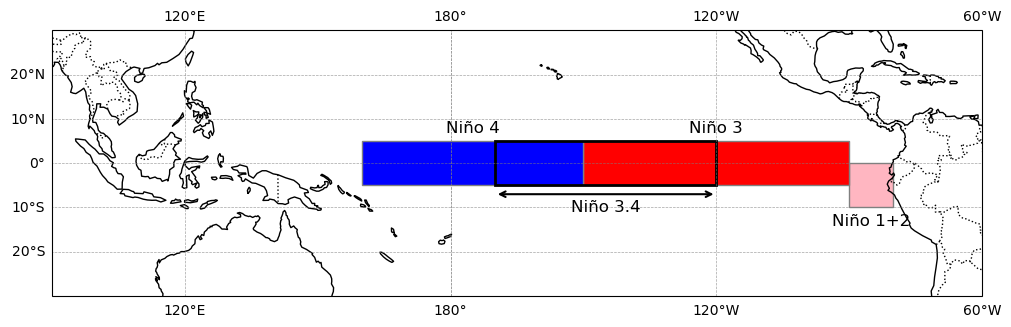

In [25]:
from matplotlib.patches import Rectangle

# Define Niño regions
nino_regions = {
    "Niño 1+2": {'lat_min': -10, 'lat_max': 0, 'lon_min': 270, 'lon_max': 280, 'color': 'lightpink'},
    "Niño 3": {'lat_min': -5, 'lat_max': 5, 'lon_min': 210, 'lon_max': 270, 'color': 'red'},
    "Niño 4": {'lat_min': -5, 'lat_max': 5, 'lon_min': 160, 'lon_max': 210, 'color': 'blue'},
}

# Create figure and axis
fig = plt.figure(figsize=(12, 6))
projection = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=projection)
ax.set_extent([90, 300, -30, 30], crs=ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')

# Plot Niño regions
for region_name, bounds in nino_regions.items():
    lat_min, lat_max = bounds['lat_min'], bounds['lat_max']
    lon_min, lon_max = bounds['lon_min'], bounds['lon_max']
    color = bounds['color']

    # Add rectangle for each region
    rect = Rectangle(
        (lon_min, lat_min),
        lon_max - lon_min,
        lat_max - lat_min,
        edgecolor='gray',
        facecolor=color,
        transform=ccrs.PlateCarree(),
    )
    ax.add_patch(rect)

    # Add text label next to each region
    if region_name == "Niño 1+2":  # Label below the box
        ax.text(
            lon_min + (lon_max - lon_min) / 2,
            lat_min - 4,  # Slightly lower than before
            region_name,
            horizontalalignment='center',
            transform=ccrs.PlateCarree(),
            fontsize=12,
            color='black'
        )
    else:  # Labels above the boxes
        ax.text(
            lon_min + (lon_max - lon_min) / 2,
            lat_max + 2,
            region_name,
            horizontalalignment='center',
            transform=ccrs.PlateCarree(),
            fontsize=12,
            color='black'
        )

# Highlight Niño 3.4 region
nino_34_bounds = {'lat_min': -5, 'lat_max': 5, 'lon_min': 190, 'lon_max': 240}
nino_34_rect = Rectangle(
    (nino_34_bounds['lon_min'], nino_34_bounds['lat_min']),
    nino_34_bounds['lon_max'] - nino_34_bounds['lon_min'],
    nino_34_bounds['lat_max'] - nino_34_bounds['lat_min'],
    edgecolor='black',
    facecolor='none',
    linewidth=2,
    transform=ccrs.PlateCarree(),
)
ax.add_patch(nino_34_rect)

# Add a two-way arrow below Niño 3.4
arrow_y = nino_34_bounds['lat_min'] - 2  # Place below the box
ax.annotate(
    '',  # No text, just the arrow
    xy=(nino_34_bounds['lon_max'], arrow_y),
    xytext=(nino_34_bounds['lon_min'], arrow_y),
    arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5),
    transform=ccrs.PlateCarree()
)

# Add "Niño 3.4" text below the arrow
ax.text(
    (nino_34_bounds['lon_min'] + nino_34_bounds['lon_max']) / 2,
    arrow_y - 3.8,  # Place below the arrow
    "Niño 3.4",
    horizontalalignment='center',
    transform=ccrs.PlateCarree(),
    fontsize=12,
    color='black'
)

# Save and show the figure
plt.savefig('Figures/Pacific_Niño_Regions_Labeled.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Plot figure 3

In [2]:

# Define the regions
regions = [
    {"name": "Region 1", "lat_min": -15, "lat_max": -5, "lon_min": 250, "lon_max": 270},
    {"name": "Region 2", "lat_min": -5, "lat_max": 5, "lon_min": 140, "lon_max": 160},
    {"name": "Region 3", "lat_min": 5, "lat_max": 15, "lon_min": 180, "lon_max": 200},
]

# Define file paths
output_file_path_wind_stress = "Data/Data Process/wind_stress_with_anomalies.nc"
output_file_path_sst = "Data/Data Process/sst_with_anomalies.nc"
output_file_path_z20 = "Data/Data Process/z20_with_anomalies.nc"

# Helper function for SST and Wind Stress using netCDF4
def extract_time_series_nc(file_path, variable_name, regions):
    try:
        # Open the dataset
        with nc.Dataset(file_path, "r") as ds:
            data = ds.variables[variable_name][:]
            latitudes = ds.variables["lat"][:]
            longitudes = ds.variables["lon"][:]
            times = ds.variables["time"][:]
            time_units = ds.variables["time"].units
            time_dates = nc.num2date(times, units=time_units)

            # Convert time to pandas datetime format
            time_dates = pd.to_datetime([f"{t.year}-{t.month:02d}-01" for t in time_dates])

            # Initialize result dictionary
            region_time_series = {}

            for region in regions:
                region_name = region["name"]
                lat_min, lat_max = region["lat_min"], region["lat_max"]
                lon_min, lon_max = region["lon_min"], region["lon_max"]

                # Create masks for the region
                lat_mask = (latitudes >= lat_min) & (latitudes <= lat_max)
                lon_mask = (longitudes >= lon_min) & (longitudes <= lon_max)

                # Extract regional data
                regional_data = data[:, lat_mask, :][:, :, lon_mask]

                # Compute mean anomaly for the region over time
                regional_mean = np.nanmean(regional_data, axis=(1, 2))

                # Store the result
                region_time_series[region_name] = pd.Series(
                    regional_mean, index=time_dates
                )

        return region_time_series

    except Exception as e:
        print(f"Error processing {variable_name} from {file_path}: {e}")
        return None

# Helper function for Z20 using xarray
def extract_time_series_z20(file_path, variable_name, regions):
    try:
        # Load the dataset using xarray
        ds = xr.open_dataset(file_path)
        data = ds[variable_name]
        data = data.where(data <= 1e6, np.nan)  # Set values greater than 1e6 to NaN


        # Convert time to pandas datetime format
        data["time"] = pd.to_datetime(data["time"].values).strftime("%Y-%m-01")

        # Initialize result dictionary
        region_time_series = {}

        for region in regions:
            region_name = region["name"]
            lat_min, lat_max = region["lat_min"], region["lat_max"]
            lon_min, lon_max = region["lon_min"], region["lon_max"]

            # Select the data for the region
            regional_data = data.sel(
                lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)
            )

            # Calculate the mean anomaly for the region over time
            regional_mean = regional_data.mean(dim=["lat", "lon"], skipna=True)

            # Store the result
            region_time_series[region_name] = pd.Series(
                regional_mean.values, index=pd.to_datetime(regional_mean["time"].values)
            )

        return region_time_series

    except Exception as e:
        print(f"Error processing {variable_name} from {file_path}: {e}")
        return None

# Extract time series for each variable
time_series_dict = {
    "sst": extract_time_series_nc(output_file_path_sst, "sst_rolling_anomaly", regions),
    "wind_stress": extract_time_series_nc(output_file_path_wind_stress, "uflx_rolling_anomaly", regions),
    "z20": extract_time_series_z20(output_file_path_z20, "z20_depth_rolling_anomaly", regions),
}

# Initialize separate DataFrames for each variable
sst_time_series = pd.DataFrame()
wind_stress_time_series = pd.DataFrame()
z20_time_series = pd.DataFrame()

# Populate DataFrames for each region and variable
for region in regions:
    region_name = region["name"]

    # SST Anomaly Time Series
    if time_series_dict["sst"]:
        sst_time_series[region_name] = time_series_dict["sst"][region_name]["1950":"2023"]

    # Wind Stress Anomaly Time Series
    if time_series_dict["wind_stress"]:
        wind_stress_time_series[region_name] = time_series_dict["wind_stress"][region_name]["1950":"2023"]

    # Z20 Anomaly Time Series
    if time_series_dict["z20"]:
        z20_time_series[region_name] = time_series_dict["z20"][region_name]["1950":"2023"]


/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_1593/2498375505.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


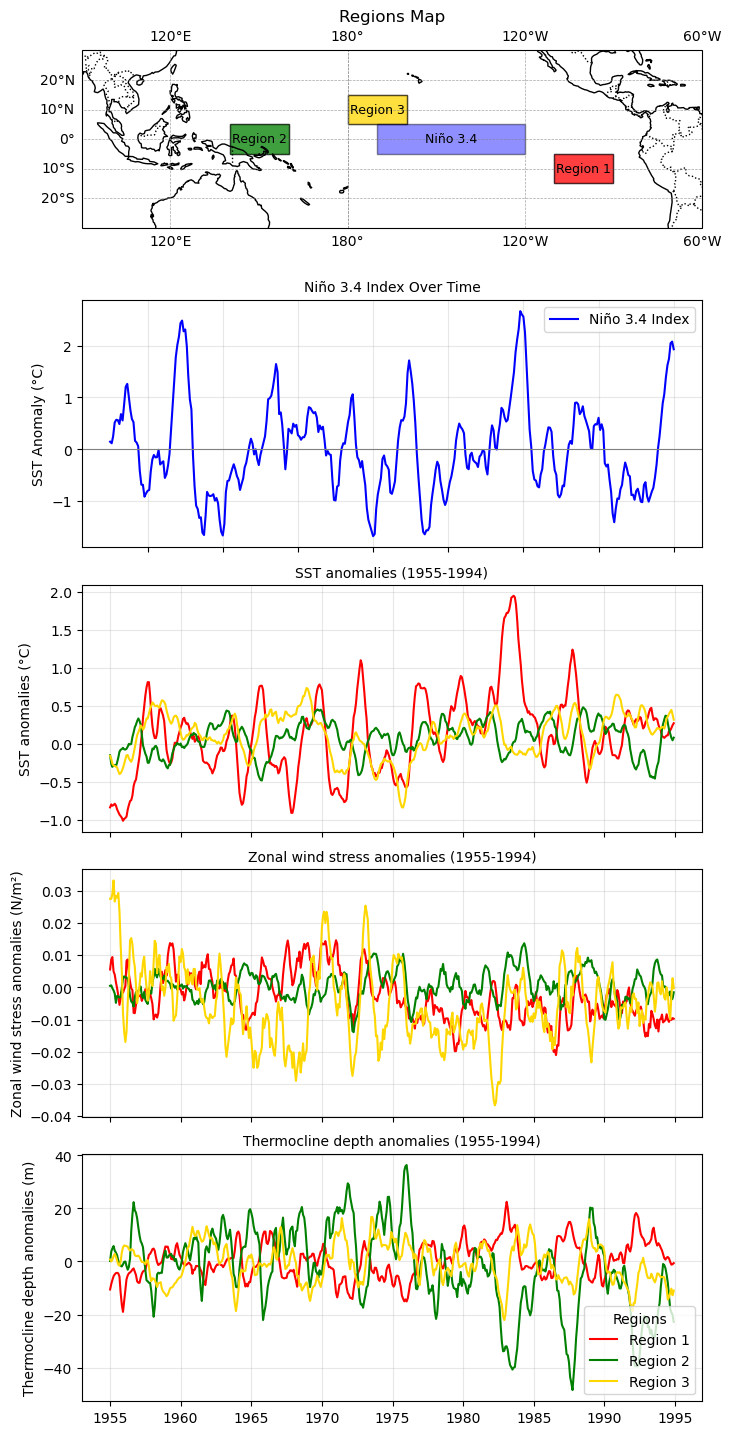

<Figure size 640x480 with 0 Axes>

Combined plot saved: Figures/Combined_Map_and_Time_Series_Tight.pdf


In [7]:
# Define regions
regions = {
    "Region 1": {'lat_min': -15, 'lat_max': -5, 'lon_min': 250, 'lon_max': 270, 'color': 'red'},
    "Region 2": {'lat_min': -5, 'lat_max': 5, 'lon_min': 140, 'lon_max': 160, 'color': 'green'},
    "Region 3": {'lat_min': 5, 'lat_max': 15, 'lon_min': 180, 'lon_max': 200, 'color': 'gold'},
    "Niño 3.4": {'lat_min': -5, 'lat_max': 5, 'lon_min': 190, 'lon_max': 240, 'color': 'blue'}  # Niño 3.4 region
}

variables = {
    "SST anomalies": sst_time_series,
    "Zonal wind stress anomalies": wind_stress_time_series,
    "Thermocline depth anomalies": z20_time_series,
}
y_labels = {
    "SST anomalies": 'SST anomalies (°C)',
    "Zonal wind stress anomalies": 'Zonal wind stress anomalies (N/m²)',
    "Thermocline depth anomalies": 'Thermocline depth anomalies (m)'
}

# Define colors for the regions in the time series plots
region_colors = {
    "Region 1": "red",
    "Region 2": "green",
    "Region 3": "gold",
}

# Define the time range to display
start_date = "1955"
end_date = "1994"

# Load Niño 3.4 anomalies data
nino34_data = pd.read_csv('Data/Data Process/nino_34_sst_anomalies.csv', parse_dates=['time'])
nino34_data.set_index('time', inplace=True)
filtered_nino34_data = nino34_data["1994-01-01":"2024-01-01"]  # Filter data from 1996 to 2024


# Create figure with subplots
fig = plt.figure(figsize=(8, 18))  # Adjusted for additional subplot
gs = gridspec.GridSpec(5, 1, hspace=0.15)  # Extra row for Niño 3.4 time series

# Map subplot
ax_map = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax_map.set_extent([90, 300, -30, 30], crs=ccrs.PlateCarree())
ax_map.coastlines()
ax_map.add_feature(cfeature.BORDERS, linestyle=':')
ax_map.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')

# Plot regions on the map
for region_name, bounds in regions.items():
    # rect = Rectangle(
    #     (bounds['lon_min'], bounds['lat_min']),
    #     bounds['lon_max'] - bounds['lon_min'],
    #     bounds['lat_max'] - bounds['lat_min'],
    #     edgecolor='black',
    #     facecolor=bounds['color'],
    #     alpha=0.5 if region_name != "Niño 3.4" else 0.25  # Lighter fill for Niño 3.4 for visibility
    # )
    lat_min, lat_max = bounds['lat_min'], bounds['lat_max']
    lon_min, lon_max = bounds['lon_min'], bounds['lon_max']
    color = bounds['color']

    # Add rectangle for each region
    rect = Rectangle(
        (lon_min, lat_min),
        lon_max - lon_min,
        lat_max - lat_min,
        edgecolor='black',
        facecolor=color,
        transform=ccrs.PlateCarree(),
        alpha=0.5 if region_name != "Niño 3.4" else 0.25  # Lighter fill for Niño 3.4 for visibility
    )
    ax_map.add_patch(rect)
    ax_map.add_patch(rect)
    ax_map.text(
        (bounds['lon_min'] + bounds['lon_max']) / 2,
        (bounds['lat_min'] + bounds['lat_max']) / 2,
        region_name,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ccrs.PlateCarree(),
        fontsize=9,
        color='black'
    )

ax_map.set_title("Regions Map", fontsize=12)

# Niño 3.4 anomalies subplot
ax_nino34 = fig.add_subplot(gs[1, 0])
ax_nino34.plot(filtered_nino34_data.index, filtered_nino34_data['nino_34_anomaly'], label='Niño 3.4 Index', color='blue')
ax_nino34.axhline(0, color='grey', lw=0.8)
ax_nino34.set_title('Niño 3.4 Index Over Time', fontsize =10)
ax_nino34.set_ylabel('SST Anomaly (°C)')
ax_nino34.set_xticklabels([])
ax_nino34.grid(alpha=0.3)
ax_nino34.legend()

# Subsequent subplots for each variable
for i, (variable_name, time_series_df) in enumerate(variables.items(), start=2):
    ax = fig.add_subplot(gs[i, 0])
    ax.set_title(f"{variable_name} ({start_date}-{end_date})", fontsize=10)
    ax.set_ylabel(y_labels[variable_name], fontsize=10)


    for region_name, color in region_colors.items():
        if region_name in time_series_df.columns:
            ax.plot(
                time_series_df.loc[start_date:end_date].index,
                time_series_df.loc[start_date:end_date, region_name],
                label=region_name,
                color=color,
                linewidth=1.5
            )

    if i == (len(variables)+1):  # Add legend only to the last time series plot
        ax.legend(title="Regions", fontsize=10, loc="lower right")
    else:
        ax.set_xticklabels([])  # Remove x-tick labels for all but the last plot
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Save and display the figure
output_file = "Figures/Combined_Map_and_Time_Series_Tight.pdf"
plt.savefig(output_file, bbox_inches="tight", dpi=300)
plt.show()

print(f"Combined plot saved: {output_file}")

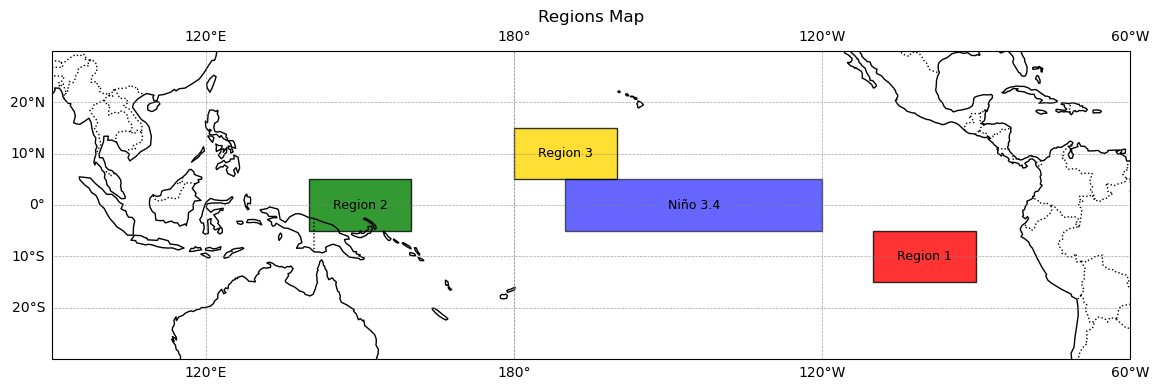

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define regions
regions = {
    "Region 1": {'lat_min': -15, 'lat_max': -5, 'lon_min': 250, 'lon_max': 270, 'color': 'red'},
    "Region 2": {'lat_min': -5, 'lat_max': 5, 'lon_min': 140, 'lon_max': 160, 'color': 'green'},
    "Region 3": {'lat_min': 5, 'lat_max': 15, 'lon_min': 180, 'lon_max': 200, 'color': 'gold'},
    "Niño 3.4": {'lat_min': -5, 'lat_max': 5, 'lon_min': 190, 'lon_max': 240, 'color': 'blue'}
}

# Create the map plot
fig, ax = plt.subplots(figsize=(14, 4), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
ax.set_extent([90, 300, -30, 30], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')

# Plot regions on the map
for region_name, bounds in regions.items():
    rect = Rectangle(
        (bounds['lon_min'], bounds['lat_min']),
        bounds['lon_max'] - bounds['lon_min'],
        bounds['lat_max'] - bounds['lat_min'],
        edgecolor='black',
        facecolor=bounds['color'],
        alpha=0.8 if region_name != "Niño 3.4" else 0.6,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)
    ax.text(
        (bounds['lon_min'] + bounds['lon_max']) / 2,
        (bounds['lat_min'] + bounds['lat_max']) / 2,
        region_name,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ccrs.PlateCarree(),
        fontsize=9,
        color='black'
    )

ax.set_title("Regions Map", fontsize=12)
plt.show()


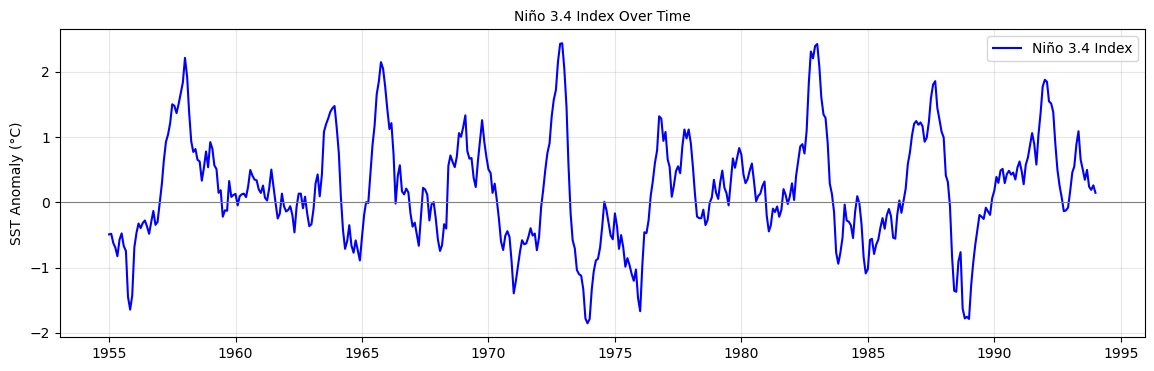

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and filter Niño 3.4 data
nino34_data = pd.read_csv('Data/Data Process/nino_34_sst_anomalies.csv', parse_dates=['time'])
nino34_data.set_index('time', inplace=True)
filtered_nino34_data = nino34_data["1955-01-01":"1994-01-01"]

# Plot Niño 3.4 anomaly time series
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(filtered_nino34_data.index, filtered_nino34_data['nino_34_anomaly'], label='Niño 3.4 Index', color='blue')
ax.axhline(0, color='grey', lw=0.8)
ax.set_title('Niño 3.4 Index Over Time', fontsize=10)
ax.set_ylabel('SST Anomaly (°C)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()


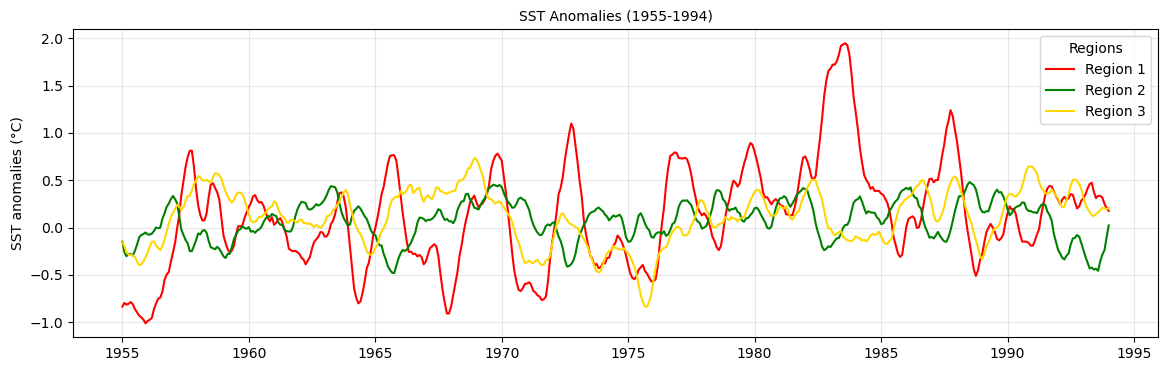

In [8]:
import matplotlib.pyplot as plt
sst_filtered = sst_time_series.loc["1955-01-01":"1994-01-01"]

# Plotting SST Anomalies
fig, ax = plt.subplots(figsize=(14, 4))
for region_name, data in sst_filtered.items():
    ax.plot(data.index, data, label=region_name, color=region_colors[region_name], linewidth=1.5)
ax.set_title("SST Anomalies (1955-1994)", fontsize=10)
ax.set_ylabel('SST anomalies (°C)', fontsize=10)
ax.legend(title="Regions")
ax.grid(alpha=0.3)
plt.show()


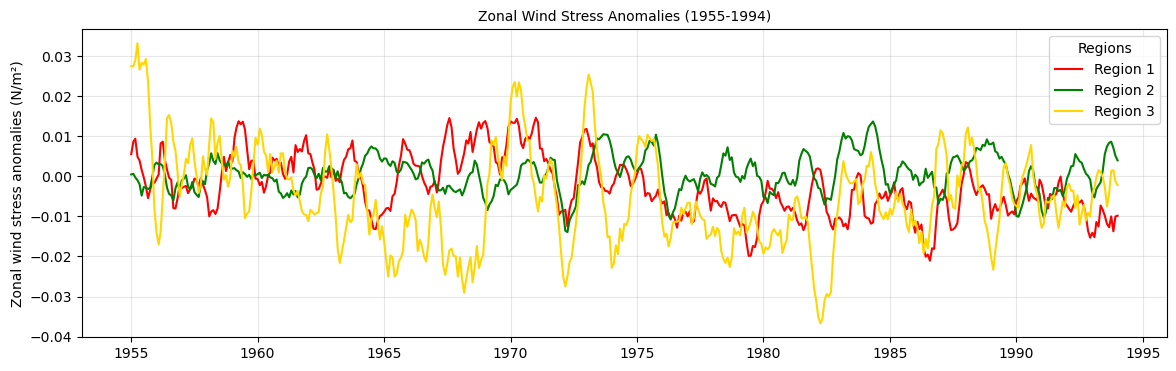

In [10]:
import matplotlib.pyplot as plt

# Filtering the data for the specified time period
wind_stress_filtered = wind_stress_time_series.loc["1955-01-01":"1994-01-01"]

# Plotting Zonal Wind Stress Anomalies
fig, ax = plt.subplots(figsize=(14, 4))
for region_name, data in wind_stress_filtered.items():
    ax.plot(data.index, data, label=region_name, color=region_colors[region_name], linewidth=1.5)
ax.set_title("Zonal Wind Stress Anomalies (1955-1994)", fontsize=10)
ax.set_ylabel('Zonal wind stress anomalies (N/m²)', fontsize=10)
ax.legend(title="Regions")
ax.grid(alpha=0.3)
plt.show()


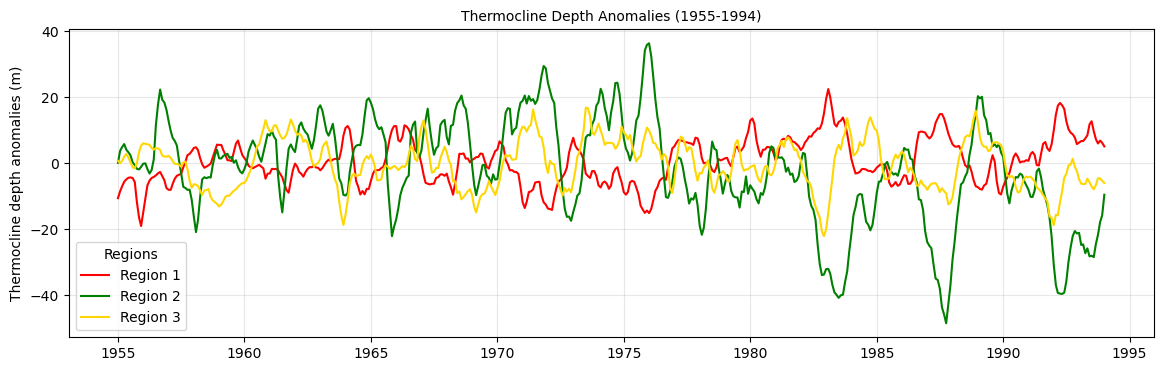

In [11]:
import matplotlib.pyplot as plt

# Filtering the data for the specified time period
z20_filtered = z20_time_series.loc["1955-01-01":"1994-01-01"]

# Plotting Thermocline Depth Anomalies
fig, ax = plt.subplots(figsize=(14, 4))
for region_name, data in z20_filtered.items():
    ax.plot(data.index, data, label=region_name, color=region_colors[region_name], linewidth=1.5)
ax.set_title("Thermocline Depth Anomalies (1955-1994)", fontsize=10)
ax.set_ylabel('Thermocline depth anomalies (m)', fontsize=10)
ax.legend(title="Regions")
ax.grid(alpha=0.3)
plt.show()